# **N-Body simulation handout 1**: How to evolve a system of dark matter particles in a 1+1D cosmological context
### *[Delon Shen](https://delonshen.com), November 11, 2024*

## Basic Idea
In cosmological dark matter only N-body simulations we numerically figure out how a system of $N$ dark matter particles evolves gravitationally.
Each particle has a physical location $\bf r$ and velocity $\bf u$.
Together they make up a mass density distribution $\rho$.
So the evolution of these particles are governed by the equations
$$\nabla_r^2 \Phi = 4\pi G \rho\tag{A}$$
$$\dot {\bf r} = {\bf u}\tag{B}$$
$$\dot {\bf u} = -\nabla_r\Phi\tag{C}$$
Solving these equations can be done iteratively. 
Suppose the initial conditon of our system is $\{\bf r_i, \bf u_i\}$. 
The recipe is this:
1. propagate ${\bf r_i} \rightarrow {\bf r_i} + {\bf u_i} \Delta t$
2. compute the mass density $\rho$ given the new position of particles 
3. compute the gravitational potential $\Phi$ from this $\rho$ using the Poisson equation
4. use this potential to update the velocities ${\bf u_i} \rightarrow {\bf u_i} - \nabla \Phi\Delta t$
5. go back to step 1

In this notebook I will walk you through implenting all the ingrediants needed to execute this recipe in a 1+1D universe that contains only matter $(\Omega_m = 1)$. 
Specifically I will walk you through how to implement a particle mesh method where forces are computed on a grid.
We will check your code in the end by applying it to a single plane wave where we analytically know how it should evolve.

## **Exercise 1**: Rewrite the equations of motion in comoving coordinates
$\newcommand{\r} { {\bf{r}} }\newcommand{\x} { {\bf{x}} }\newcommand{\v} { {\bf{v}} }\newcommand{\u} { {\bf{v}} }\newcommand{\p} { {\bf{p}} }$
One complication of doing a *cosmological* N-body simulation instead of a normal N-body simulation is that the universe is expanding.
This expansion is parameterized by an expansion parameter $a$ or equivalently the Hubble parameter $H = \dot a / a$. 
This continual expansion of the universe is inconvinient for numerical simulation. 
So instead we will work in *comoving coordinates* allowing the size of our simulation to stay fixed.
However, changing to comoving coordinates causes wacky changes to our evolution equations (A-C) above. 
This first exercise will have you work out explicitly what happens [1].

Comoving coordinates $\bf x$ are related to physical cordinates $ \r$ via $ \r = a \x$.
Recall that this means
$$\u = \dot {\r} = a \dot {\x}  + \dot a \x \equiv \v +  H {\r} = \textrm{Peculiar Velocity} + \textrm{Hubble Flow}$$
where we defined
$$\textrm{Peculiar Velocity} = \v = a\dot {\x}.$$
*[1]: We'll be following the [conventions of Anatoly Klypin](https://www.skiesanduniverses.org/resources/KlypinNbody.pdf) which is also the convention [Andrey Kravtsov's notes](https://astro.uchicago.edu/~andrey/Talks/PM/pm.pdf) follow.*

### **Exercise 1(a)** Rewrite $\dot {\bf r} = {\bf u}$ in terms of comoving coordinates
Define a new *comoving momentum* variable $\p$:
$$\textrm{Comoving Momentum} = \p \equiv a {\v}$$
Show that the time evolution equation for a particle postion in comoving space is given by
$$\boxed{\frac{d\x}{da} = \frac{\p}{\dot a a^2}}$$

### **Exercise 1(b)** Rewrite $\dot \u = -\nabla_r \Phi$ in terms of comoving coordinates
Define a new *peculiar potential* variable $\phi$:
$$\textrm{Peculiar Potential} = \phi \equiv \Phi + \frac 1 2 a \ddot a \x^2$$
Show that the time evolution equation for a particle momentum in comoving space is given by
$$\boxed{\frac{d\p}{da} = -\frac{\nabla \phi}{\dot a}}$$
where **$\nabla$ is the derivative with respect to $\x$, not $\r$**.

### **Exercise 1(c)** Rewrite the Poisson equation in terms of comoving coordinates
Show that the poisson equation equation in terms of this peculiar potential is 
$$\boxed{\nabla^2 \phi = 4 \pi G a^2 \bar\rho \delta}$$
where $\bar\rho$ is the average density and we defined the density contrast 
$$\delta = \frac{\rho - \bar\rho}{\bar\rho}$$
You will need to use the **Raychaudhuri equation** (e.g. see Eq. (2.137) of Baumann) applied to dark matter:
$$\frac{\ddot a}{a} = -\frac 4 3\pi G \bar \rho $$

### **Exercise 1(d)** Rewrite the comoving evolution equations in terms of dimensionless variables
When doing things numerically, it is generally wise to make things dimensionless. 
Lets do this to our evolution equations in comoving coordintes. 
Define new dimensionless variables
$$\tilde \x = \frac 1 a \frac \r {r_0} \qquad \tilde t = \frac { t}{t_0}\qquad \tilde \p = a \frac \v {v_0}\qquad \tilde \phi = \frac \phi {\phi_0} \qquad \tilde \rho = a^3 \frac \rho {\rho_0}$$
Choosing characteristic dimensionless values like $r_0$ is somewhat arbitrary. 
A natural characteristic lengthscale is the comoving size of the box:
$$r_0 = L_{\rm box, comoving}$$
For everything else we will use
$$ t_0 = \frac 1 {H_0} \qquad v_0 = \frac{r_0}{t_0}\qquad \phi_0 = v_0^2 \qquad \rho_0 = \frac{3 H_0^2}{8 \pi G}. $$
Show that in terms of these dimensionless variables, the dynamical equations in comoving coordinates becomes
$$\boxed{\frac{d\tilde \x}{da} = \frac{\tilde \p}{ a^{3/2}}\qquad \frac{d\tilde \p}{da} = - \sqrt{a} \tilde\nabla \tilde \phi \qquad \tilde\nabla^2 \tilde \phi = \frac 3 {2a} \tilde \delta \qquad \textrm{where } \tilde \nabla = \partial /\partial \tilde x_i \textrm{ and }\tilde \delta = \tilde \rho - 1}
\tag{D}  $$
You will need to use the **Friedmann equation** (e.g. see Eq. (2.144) of Baumann) applied to universe filled with only matter ($\Omega_m=1$):
$$\frac{H^2}{H_0^2} = a^{-3} $$

### **Exercise 1(e)** Simplify the equations from 3D to 1D by considering interactions from infinite sheets
Now we will specialize to 1+1D which is the topic of your project. Suppose the initial conditions of your universe is that you have a series of infinite sheets of uniform mass. Imagine a stack of infinite size papers fill your expanding universe. Convince yourself by symmetry that this reduces the 3D evolution equations you derived above to 1D equations
$$\boxed{\frac{d\tilde x}{da} = \frac{\tilde p}{ a^{3/2}}\qquad \frac{d\tilde p}{da} = - \sqrt{a} \tilde\nabla \tilde \phi \qquad \tilde\nabla^2 \tilde \phi = \frac 3 {2a} \tilde \delta \qquad \textrm{where } \tilde \nabla = \partial /\partial \tilde x \textrm{ and }\tilde \delta = \tilde \rho - 1}
\tag{1}  $$
These will be the equations we will numerically solve!

## Moral of Exercise 1
So we've spent some time deriving Eq. 1. Like I said, these are the equations we will actually numerically solve. 
Replicating them here very quickly
$$\boxed{\frac{d\tilde x}{da} = \frac{\tilde p}{ a^{3/2}}\qquad \frac{d\tilde p}{da} = - \sqrt{a} \tilde\nabla \tilde \phi \qquad \tilde\nabla^2 \tilde \phi = \frac 3 {2a} \tilde \delta \qquad \textrm{where } \tilde \nabla = \partial /\partial \tilde x \textrm{ and }\tilde \delta = \tilde \rho - 1}
\tag{1}  $$
We can now refine the recipe I gave earlier.
Suppose the initial conditon of our system is $\{\tilde x_i, \tilde p_i\}$. 
The recipe is now this:
1. propagate $\tilde x_i \rightarrow \tilde x_i + \tilde p_i  a^{-3/2} \Delta a $
2. compute the mass density $\rho$ given the new position of particles 
3. compute the gravitational potential $\phi$ from this $\rho$ using the Poisson equation
4. use this potential to update the velocities $\tilde p_i \rightarrow \tilde p_i - \sqrt{a}\tilde\nabla \tilde\phi\Delta a$
5. go back to step 1

I will tell you in more detail how we will integrate these equations shortly. We will use this method called Leapfrog integration which is the like the next order correction to the Euler time step you may be familiar with[2]. 
But before that we need to assemble some ingrediants. 
Namely we will now figure out how to 
- Compute the mass density $\rho$ given the position of particles
- Compute the gravitational potential from this mass density $\rho$

[2]: If you haven't seen Euler time step before, this is (shockingly) one the [first thing Feynman talks about in his lectures](https://www.feynmanlectures.caltech.edu/I_09.html#Ch9-S6) from the 1960s.

## **Exercise 2**. Compute the mass density $\rho$ given a set of particle positions
As a reminder, we will be using the particle mesh method which compute the forces $d\tilde p / da$ on a grid. 
Consider a grid with $N_g$ cells.
Lets also assume all of our $N$ particles have the same mass which we can arbitrarily set to $1 / N$. 
There are various schemes to numerically compute a density $\rho$ given a discrete list of particles $\{x_i\}_{i=1}^N$. 
We will use for this project what is call **Cloud in Cell**(CIC). 
In this scheme we approximate each particle as having some size that is equal to the size of our grid and that mass is uniformly distributed within the particle.

In [1]:
def periodic_boundary(x):
    #given an position, correctly
    #change it to assert periodic
    #boundary conditions
    if(x <= 0.):
        x += 1
    if(x >= 1.):
        x -= 1
    return x

def array_periodic_boundary(x):
    x[x>=1.] -=1.
    x[x<0.]  +=1.
    return x


# in this notebook I have included two implementations of `CIC_deposit`
# the first one here is much more transparent but very slow 
# the implementation in the cell below which is what we will use 
# for the rest of the notebook does the exact samething but much faster
# because all the operations are vectorized.
# both of these come basically from Tom Abel with minor changes
def _CIC_deposit(x, Ngrid = 100):
    """
    x: position of particles in our dimensionless variable
        by definition this means that x in [0,1]
    Ngrid: number of grid elements for particle mesh

    returns rho which is a list size Ngrid that contains the mass density in a grid cell
    """
    dx = 1./Ngrid # we assume the size of each particle is the size of a grid cell
    rho = np.zeros(Ngrid)
    m   = 1 / len(x) # assume all particles have the same mass

    for i in range(len(x)):
        #figure out bounds of this particle
        right = x[i] + 0.5 * dx 
        right = periodic_boundary(right)
        left  = right - dx
        left  = periodic_boundary(left)

        #figure out which cells to put the mass in
        index = int(right // dx)
        frac  = (right - index*dx)/dx #fraction of mass in the right cell vs left cell

        rho[index] += frac * m
        rho[index-1] += (1.-frac) * m

    return rho * Ngrid

In [2]:
def CIC_deposit(x,Ngrid=100):
    """
    x: position of particles in our dimensionless variable
        by definition this means that x in [0,1]
    Ngrid: number of grid elements for particle mesh

    returns rho which is a list size Ngrid that contains the mass density in a grid cell
    """
    dx = 1./Ngrid
    rho = np.zeros(Ngrid)
    m   = 1 / len(x) # assume all particles have the same mass
    
    left = x-0.5*dx
    right = left+dx
    xi = np.int32(left/dx)
    frac = (1.+xi-left/dx)
    ind = np.where(left<0.)
    frac[ind] = (-(left[ind]/dx))
    xi[ind] = Ngrid-1
    xir = xi.copy()+1
    xir[xir==Ngrid] = 0
    rho  = np.bincount(xi,  weights=frac*m, minlength=Ngrid)
    rho2 = np.bincount(xir, weights=(1.-frac)*m, minlength=Ngrid)

    rho += rho2
    
    return rho*Ngrid

## **Exercise 3** Compute the gravitational potential $\phi$ given density $\rho$
Now our task is to numerically solve the Poisson equation
$$\tilde \nabla^2 \tilde \phi = \frac 3 {2a} (\tilde \rho - 1) $$
The first step is to approximation $\tilde \nabla^2$ with [finite differences](https://en.wikipedia.org/wiki/Finite_difference). 
Let $i$ index grid cells.
$$ \tilde \nabla^2 \tilde \phi_i \approx N_{\rm grid}^2 (\tilde \phi_{i-1}+ \tilde \phi_{i+1} - 2 \tilde \phi_i)= \frac 3 {2a}(\tilde \rho _i - 1)$$
Where recall that in our convention $\tilde x \in [0,1]$ and thus the size of a grid cell is $1 / N_{\rm grid}$. 
So now we have reduced solving the Poisson equation to a system of $N_{\rm grid}$ linear equations. 
As with all linear things, a wise thing to do is try and find the corresponding Green's function.
To start lets write the finite difference expression as a linear matrix equation:
$${\sf A}\begin{bmatrix}\tilde \phi_1 \\ \tilde \phi_2 \\ \vdots \\ \tilde \phi_{N_g} \end{bmatrix} = \begin{bmatrix}\tilde \delta_1 \\ \tilde \delta_2 \\ \vdots \\ \tilde \delta_{N_g} \end{bmatrix} \Leftrightarrow  {\tilde\delta} = {\sf A}{\tilde \phi} $$
where the matrix $\sf A$ is periodic, has $-2$ along it's diagonal and $1$ in the nearest off-diagonal components:
$${\sf A} = \left(\frac 3 {2a N_{\rm grid}^2} \right)^{-1}\begin{bmatrix} -2 & 1 & & \\ 1 & -2  &  \ddots& \\ & \ddots & \ddots & 1 \\ & & 1 & -2  \end{bmatrix} \Leftrightarrow {\sf A}_{i,j} =\left(\frac 3 {2a N_{\rm grid}^2} \right)^{-1} \times \begin{cases} -2 & |i-j|=0\\ 1 & |i-j|=1 \\ 0 & \textrm{else}\end{cases}$$
because ${\sf A}_{i,j}$ depends only on the difference $i-j$
we can define a vector $\mathcal A$ that contains all the same information as the matrix $\sf A$.
With this vector, the system can be written as a convolution
$${\tilde\delta} = {\sf A}{\tilde \phi}  \equiv \mathcal A * \tilde \phi\xrightarrow{\textrm{Fourier Transform}} \tilde \delta = (\mathcal F \mathcal A) \tilde \phi \Leftrightarrow \tilde \phi = G\tilde \delta $$
where we have defined $G$, the the Green's function, to be the $(\mathcal F \mathcal A)^{-1}$
$$
\begin{align*}
(\mathcal F \mathcal A)_\ell &= \left(\frac 3 {2a N_{\rm g}^2} \right)^{-1} \sum_{g = 0}^{N_g-1} a_i e^{-i 2\pi(g\ell) / N_g} \\
&= \left(\frac 3 {2a N_{\rm g}^2} \right)^{-1} \left[-2\times e^0 + 1 e^{-i 2\pi(1\times \ell) / N_g}  + 1 e^{-i 2\pi([N_g-1]\times \ell) / N_g}  \right] \\
&=    \left(\frac 3 {2a N_{\rm g}^2} \right)^{-1} \left[-2 + 2 \cos (2\pi \ell / N_g)  \right]\\
&=    \left(\frac 3 {2a N_{\rm g}^2} \right)^{-1} \times -4 \sin(k_\ell / 2)^2
\end{align*}
$$
Where we defined $k_\ell = 2\pi \ell / N_g$. Thus the appropriate Green's function is
$$ 
\Rightarrow G = - \frac 3 {8a N_{\rm g}^2} \times \left[\sin(k_\ell /2)^2 \right]^{-1} \Rightarrow \boxed{\tilde \phi(k_\ell) = - \frac 3 {8a N_{\rm g}^2} \times \left[\sin(k_\ell /2)^2 \right]^{-1}\times  \tilde\delta_\ell }$$
The potential can then be found by an inverse Fourier transform $\phi(x) = (\mathcal F^{-1}\phi_\ell)(x)$. The singularity at $\ell=0$ can be handled by setting $\phi({k_\ell=0})=0$.

With this theory in hand, implement a function that computes $\phi$ given some density $\rho$ and the Poisson equation

In [3]:
import numpy as np
def solve_poisson(rho, a):
    Ngrid = len(rho)
    
    delta_l = np.fft.fft(rho - 1)
    ell   = 2 * np.pi * np.fft.fftfreq(Ngrid)

    phi_l = np.zeros_like(ell, dtype=np.complex128)
    phi_l[1:] = (- 3 / (8 * a * Ngrid**2) * delta_l[1:] / (np.sin(ell[1:] / 2)**2))
    phi_l[0] = 0

    phi_x = (np.fft.ifft(phi_l)).real
    return phi_x

## **Capstone Problem:** Evolve a 1D plane wave
Now that we have assembled all the pieces, we can execute our recipe to numerically integrate the evolution equation
$$\boxed{\frac{d\tilde x}{da} = \frac{\tilde p}{ a^{3/2}}\qquad \frac{d\tilde p}{da} = - \sqrt{a} \tilde\nabla \tilde \phi \qquad \tilde\nabla^2 \tilde \phi = \frac 3 {2a} \tilde \delta \qquad \textrm{where } \tilde \nabla = \partial /\partial \tilde x \textrm{ and }\tilde \delta = \tilde \rho - 1}
\tag{1}  $$
We have written code to compute $\tilde\rho$ given a bunch of particle positions $\tilde x$ and then numerically solve the Poisson equation quickly with FFT which gives us $\tilde\phi$.
Now all there is to do is initialize and numerically evolve a system of $N_p$ particles.
Before we use our code to simulate real cosmology, we will test it out on the evolution of a simple system that we analytically understand the evolution of: a plane wave. 

### Analytical result for the 1D plane wave
This part of [Andrey's notes](https://astro.uchicago.edu/~andrey/Talks/PM/pm.pdf) are in my opinion more digestible than the first part so I will refer you to slides 20-26 of those notes for more details and references.
I will also talk about this in more detail in the next handout.
Basically, you start out with a uniform mass distribution in space but with some tiny inital velocity field which causes mass to want to move to the center of the universe.
The initial position of a particle is usually called the Lagrange position $q$. 
In the Zeldovich approximation the trajectory of this particle as a function of scale factor is given by
$$ x(a) = q + a \times A\sin(2\pi q)$$ 
The momentum of the particle on the other hand is given by 
$$ p(a) = a v(a) = a \times (a \dot x) = a \times (a \dot a \times A \sin(2\pi q))$$
The inital amplitude of the velocity field $A$ basically sets what scale factor shell-crossing occurs. 
More specifically, if you want shell crossing to occur at $a_{\rm cross}$ then you can derive the correct amplitude $A$ is 
$$
A = (a_{\rm cross} \times 2  \pi)^{-1}.
$$

### Numerically evolving a 1D plane wave
So knowing analytically how to derive the evolution of this system is nice. 
What's nicer however is that if you're lazy and don't want to figure things out analytically, you can get the exact same results by numerically evolving an N-body system.
I have been sketching out this recipe throughout this notebook but now let me make everything explicit. 
We will use a form of Leapfrog integration which is a second order method (wheras the possibly more familiar Euler time-step is a first-order method).
Suppose we have some initial conditions $\{\tilde x_i(a_{\rm init}), \tilde p_i(a_{\rm init})\}_{i=1}^{N_p}$.
The recipe is
1. Compute the potential given the $\{\tilde x_i(a_{\rm init})\}_{i=1}^{N_p}$
2. Compute the evolution of the momentum for half a timestep $$\tilde p_i(a_{\rm init} + \Delta a / 2) = \tilde p_i(a_{\rm init}) - \sqrt{a} \times \tilde\nabla\tilde\phi \times \Delta a / 2.$$ This is called the "kick" step. Here $\tilde \nabla \tilde\phi$ is computed with finite differences that you should now be pretty comfortable with after the previous exercise. 
3. Compute the evolution of position for a whole timestep $$\tilde x_i(a_{\rm init} + \Delta a) = \tilde x_i(a_{\rm init}) + a^{-3/2}\tilde p_i(a_{\rm init} + \Delta a / 2)  \times \Delta a.$$
This is called the "drift" step.
4. Compute the evolution of the momentum for another half a timestep $$\tilde p_i(a_{\rm init} + \Delta a) = \tilde p_i(a_{\rm init} + \Delta a / 2) - \sqrt{a + \Delta a / 2} \times \tilde\nabla\tilde\phi \times \Delta a / 2.$$ This is once again the "kick" step. 
5. Go back to step 1

This scheme is called the kick-drift-kick scheme for numerical integration. **Your job is to implement this scheme and numerically evolve a plane wave.**
Start your evoluation at redshift 10, $a_{\rm init} = 0.1$ and set $a_{\rm cross} = 0.5$.
The initial conditions of your particles will then be set by the Zeldovich approximation.
$$q = \left\{ \frac i  {N_p - 1}\right\}_{i=0}^{N_p-1}$$
$$x(a_{\rm init}) = q + a_{\rm init} \times A \sin(2 \pi q)$$
$$p(a_{\rm init}) = a_{\rm init} \times (\sqrt{a_{\rm init}} \times A \sin(2\pi q))$$
This idea of using an analytical result to set initial conditions of N-body simulations is extremly useful as you will see once you run your realistic cosmological N-body simulation beyond this toy example.

Compare this to the analytical results in order to check all the code we've written in this handout.

In [12]:
import matplotlib.pyplot as plt

  0%|          | 0/9011 [00:00<?, ?it/s]

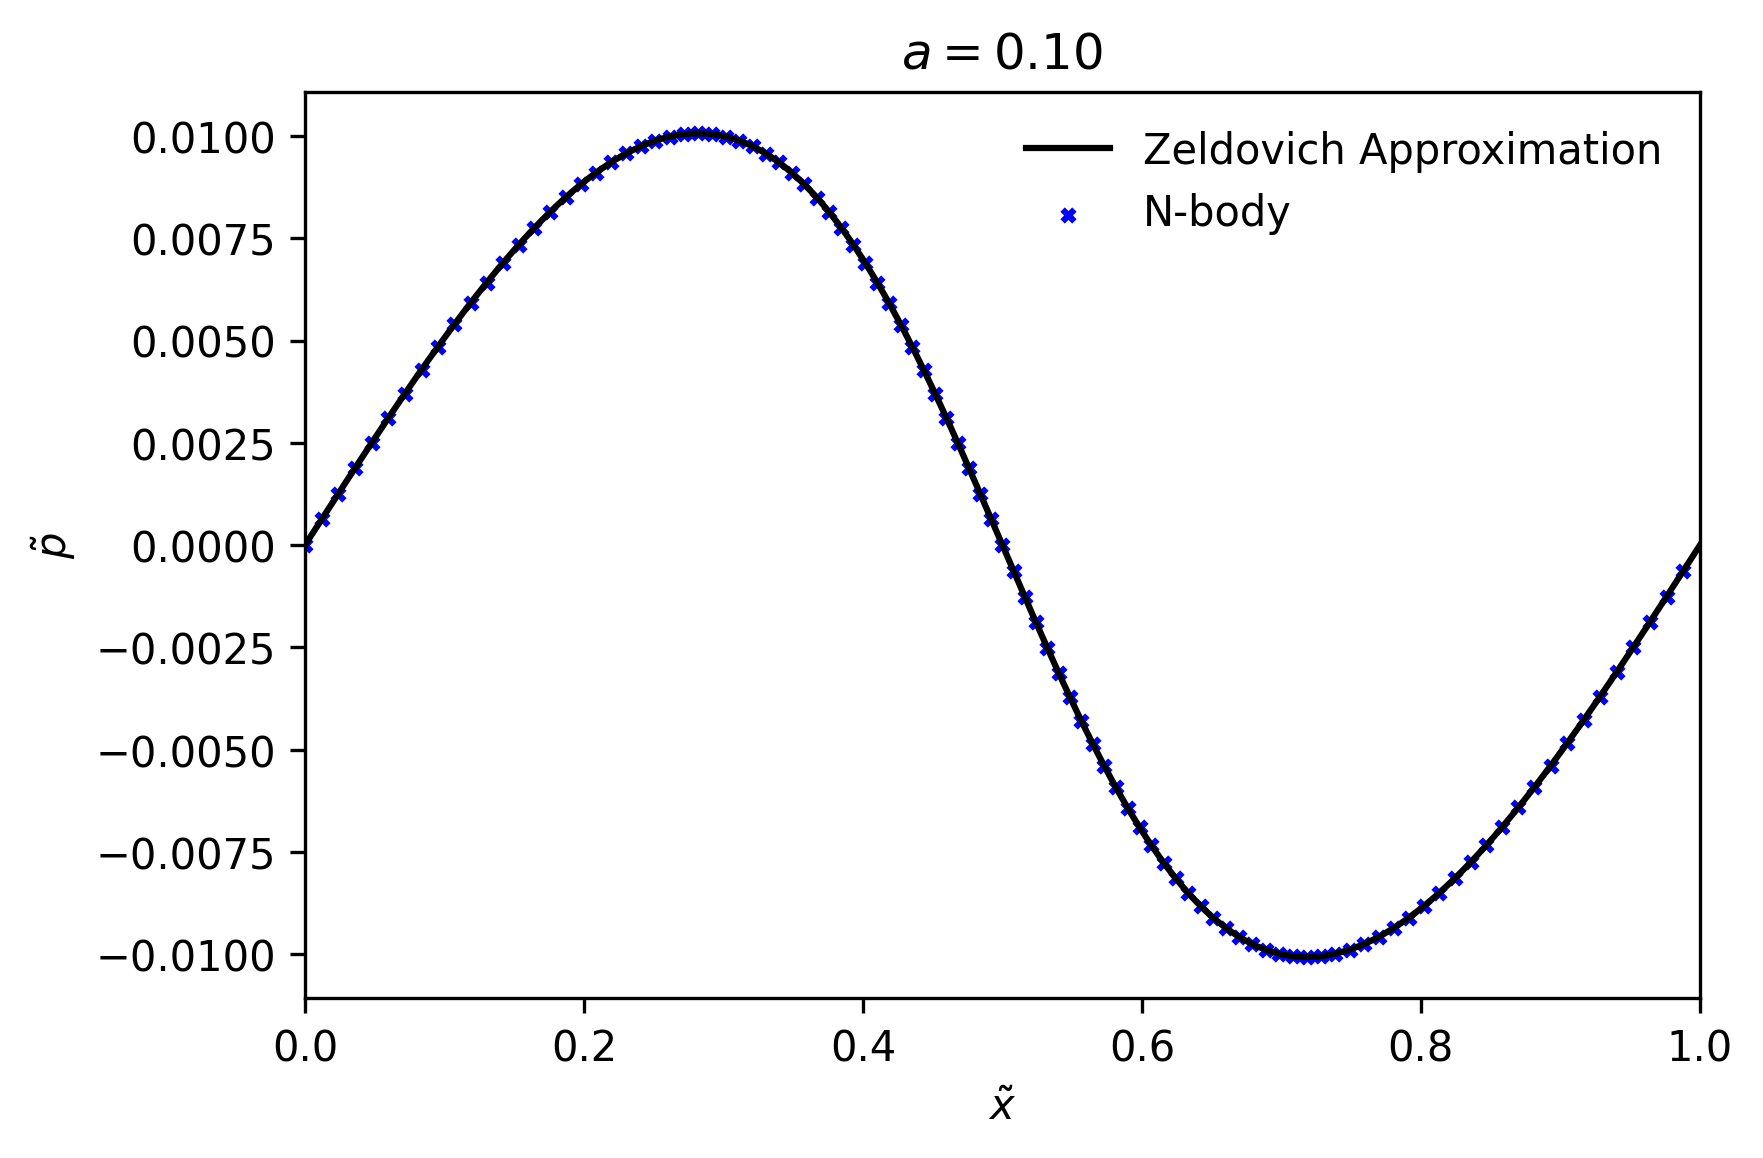

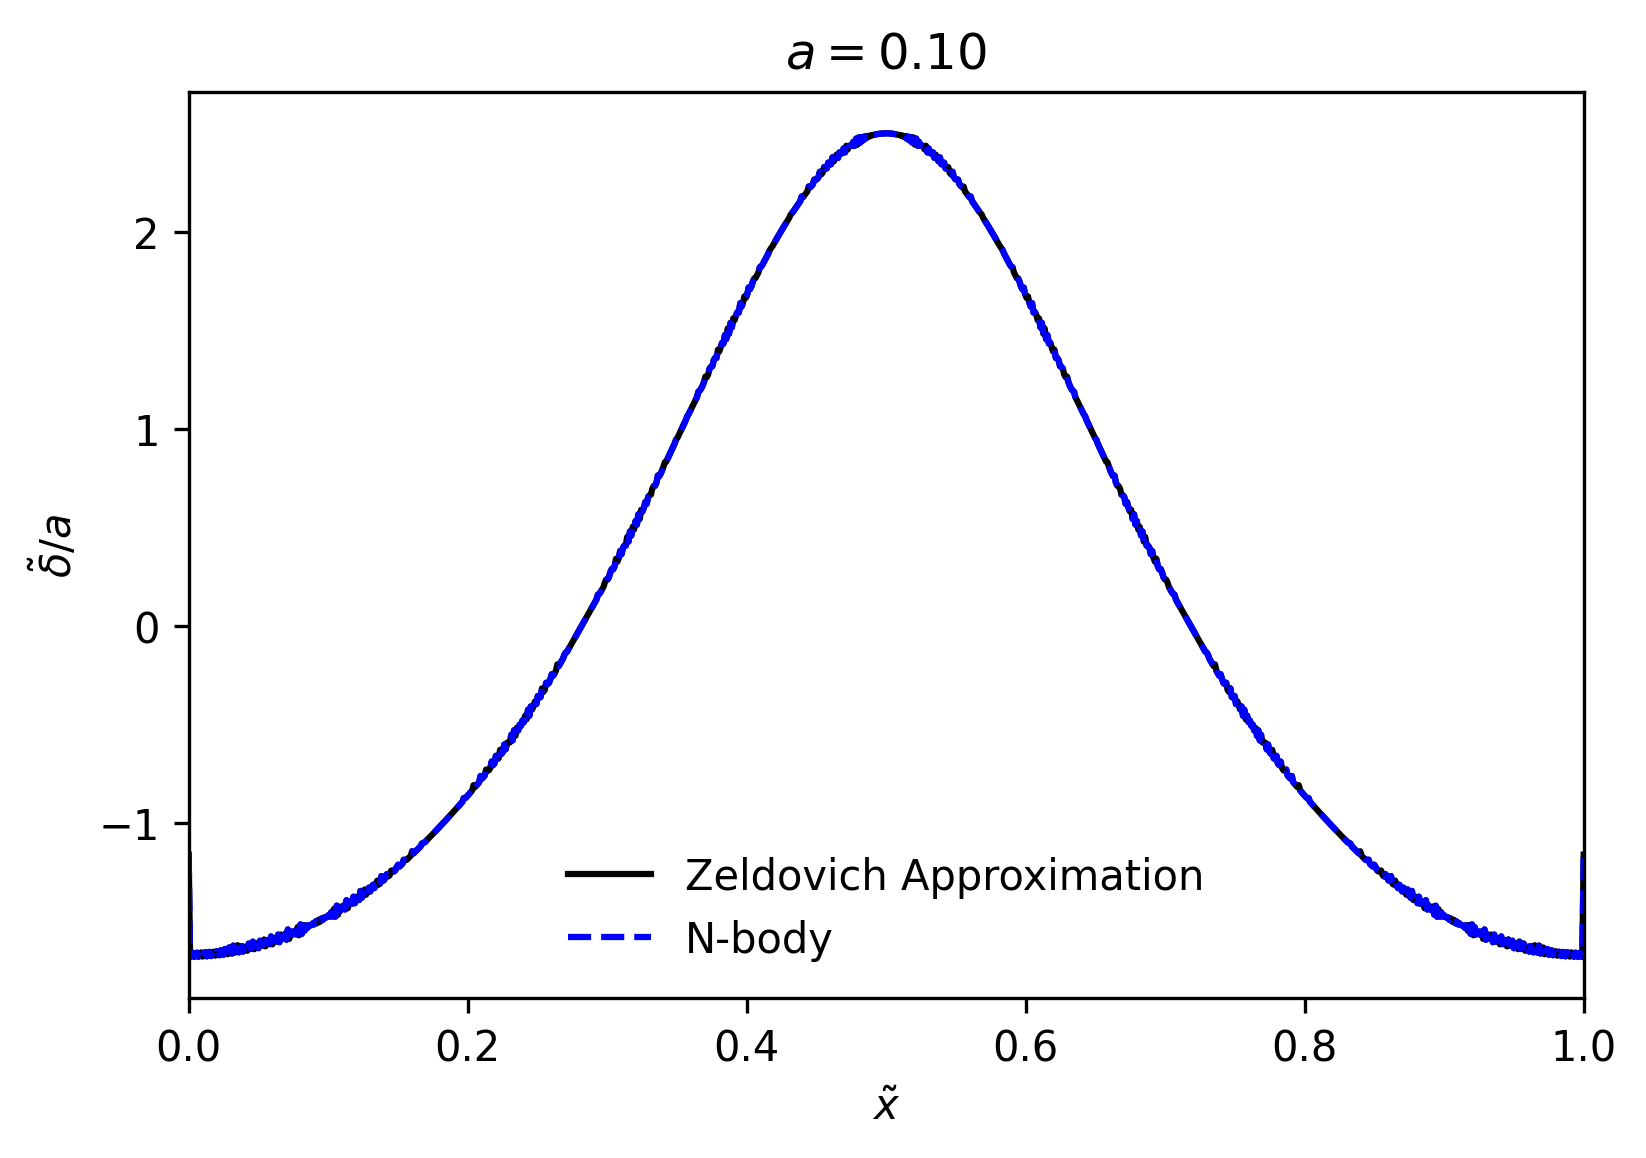

 11%|█         | 988/9011 [00:01<00:07, 1122.29it/s]

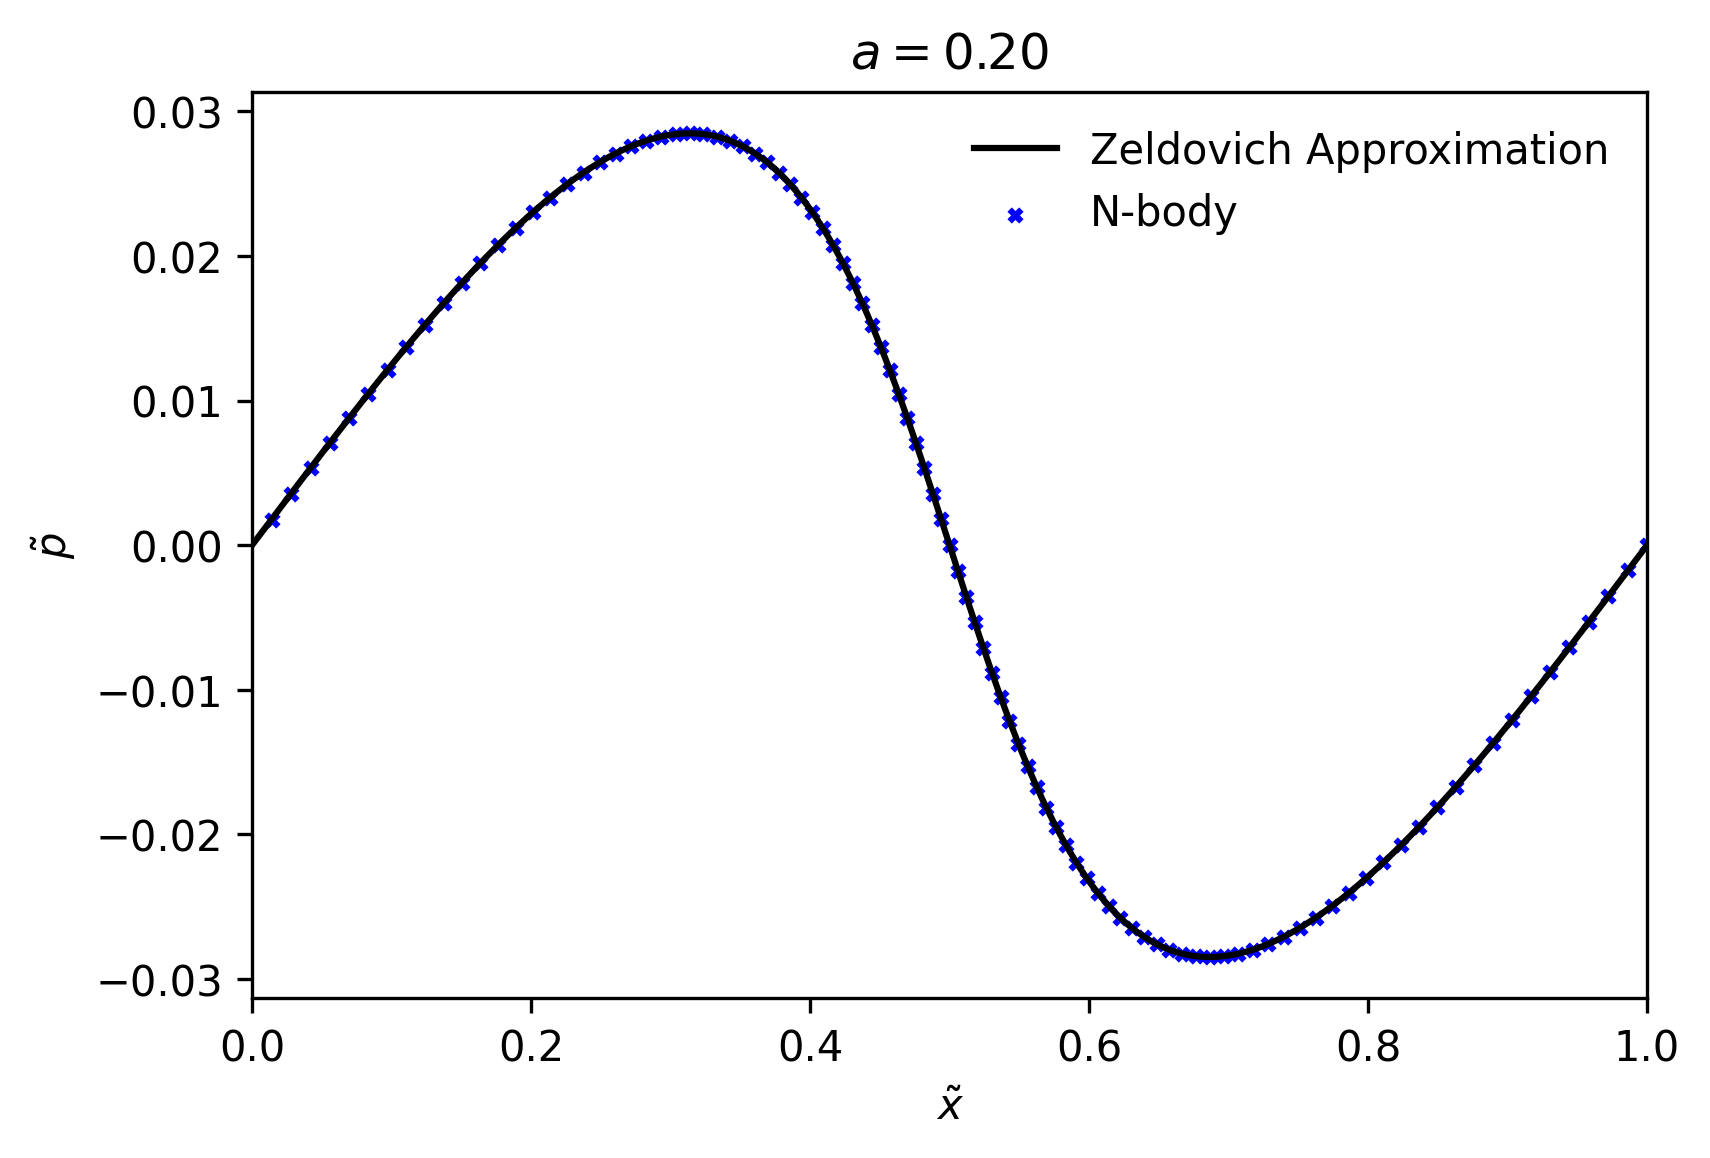

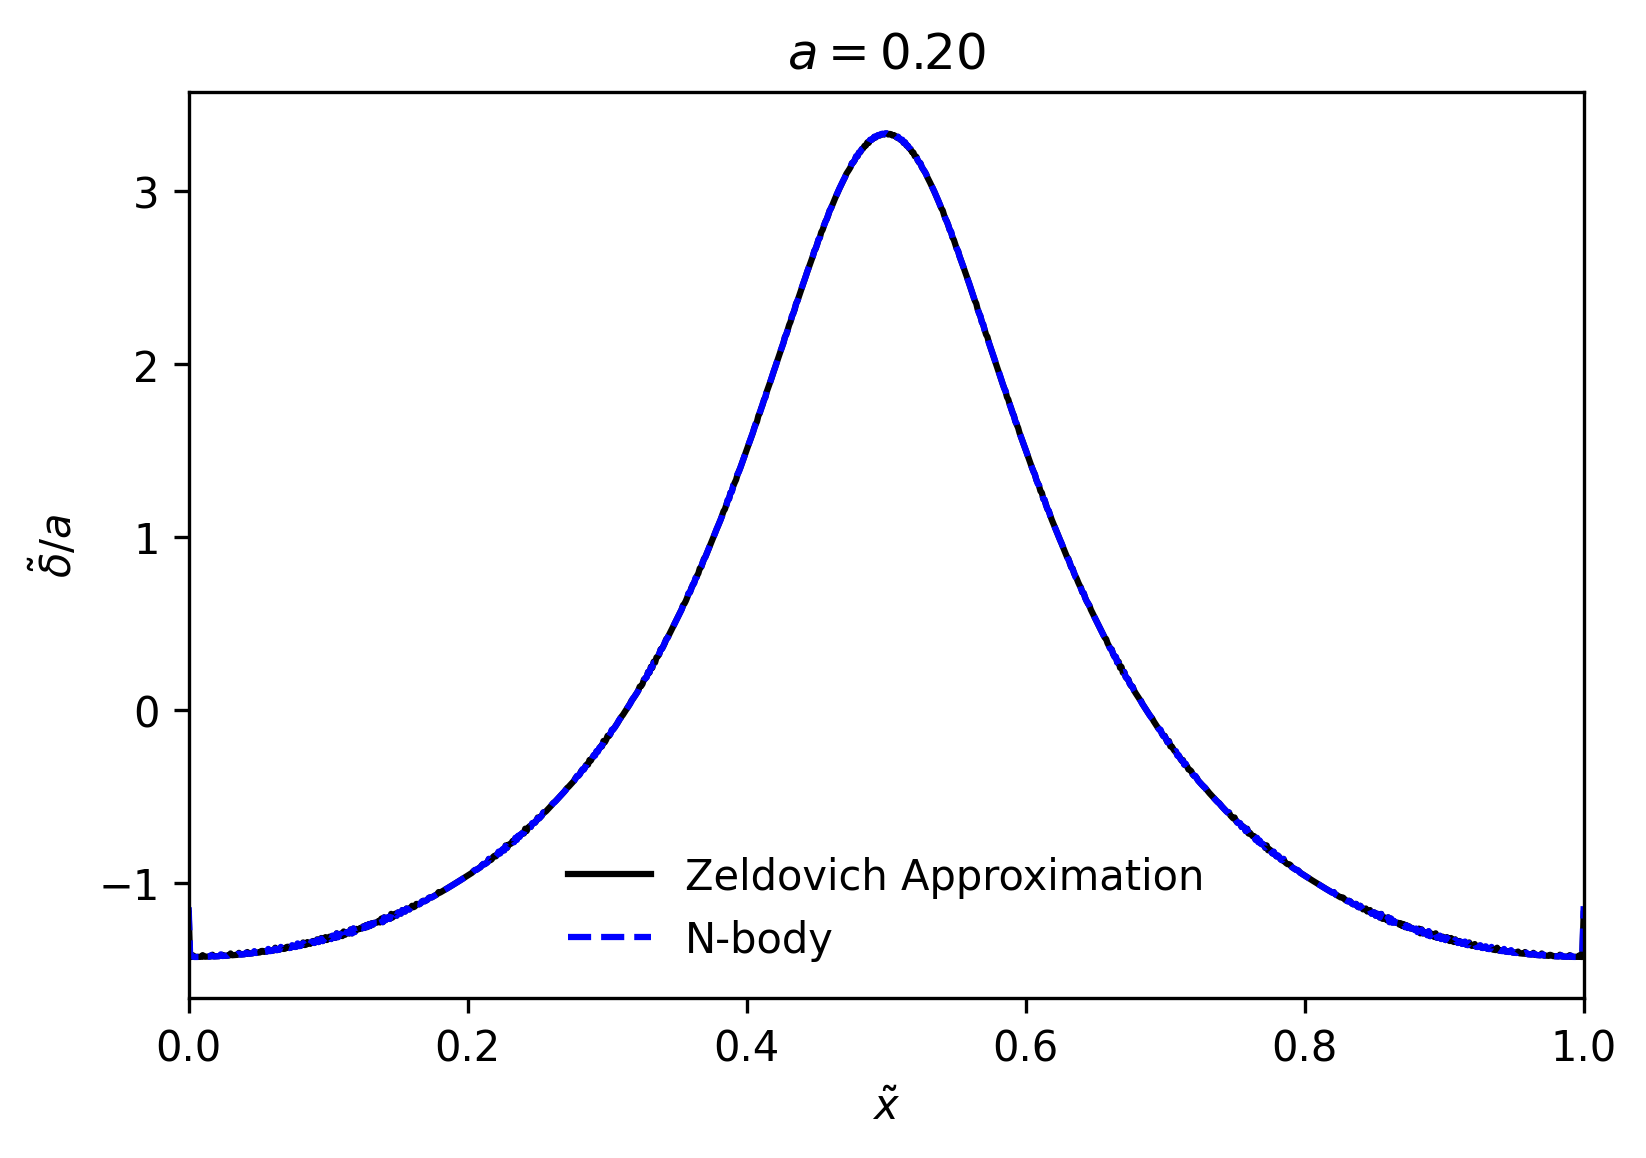

 22%|██▏       | 1992/9011 [00:02<00:06, 1121.60it/s]

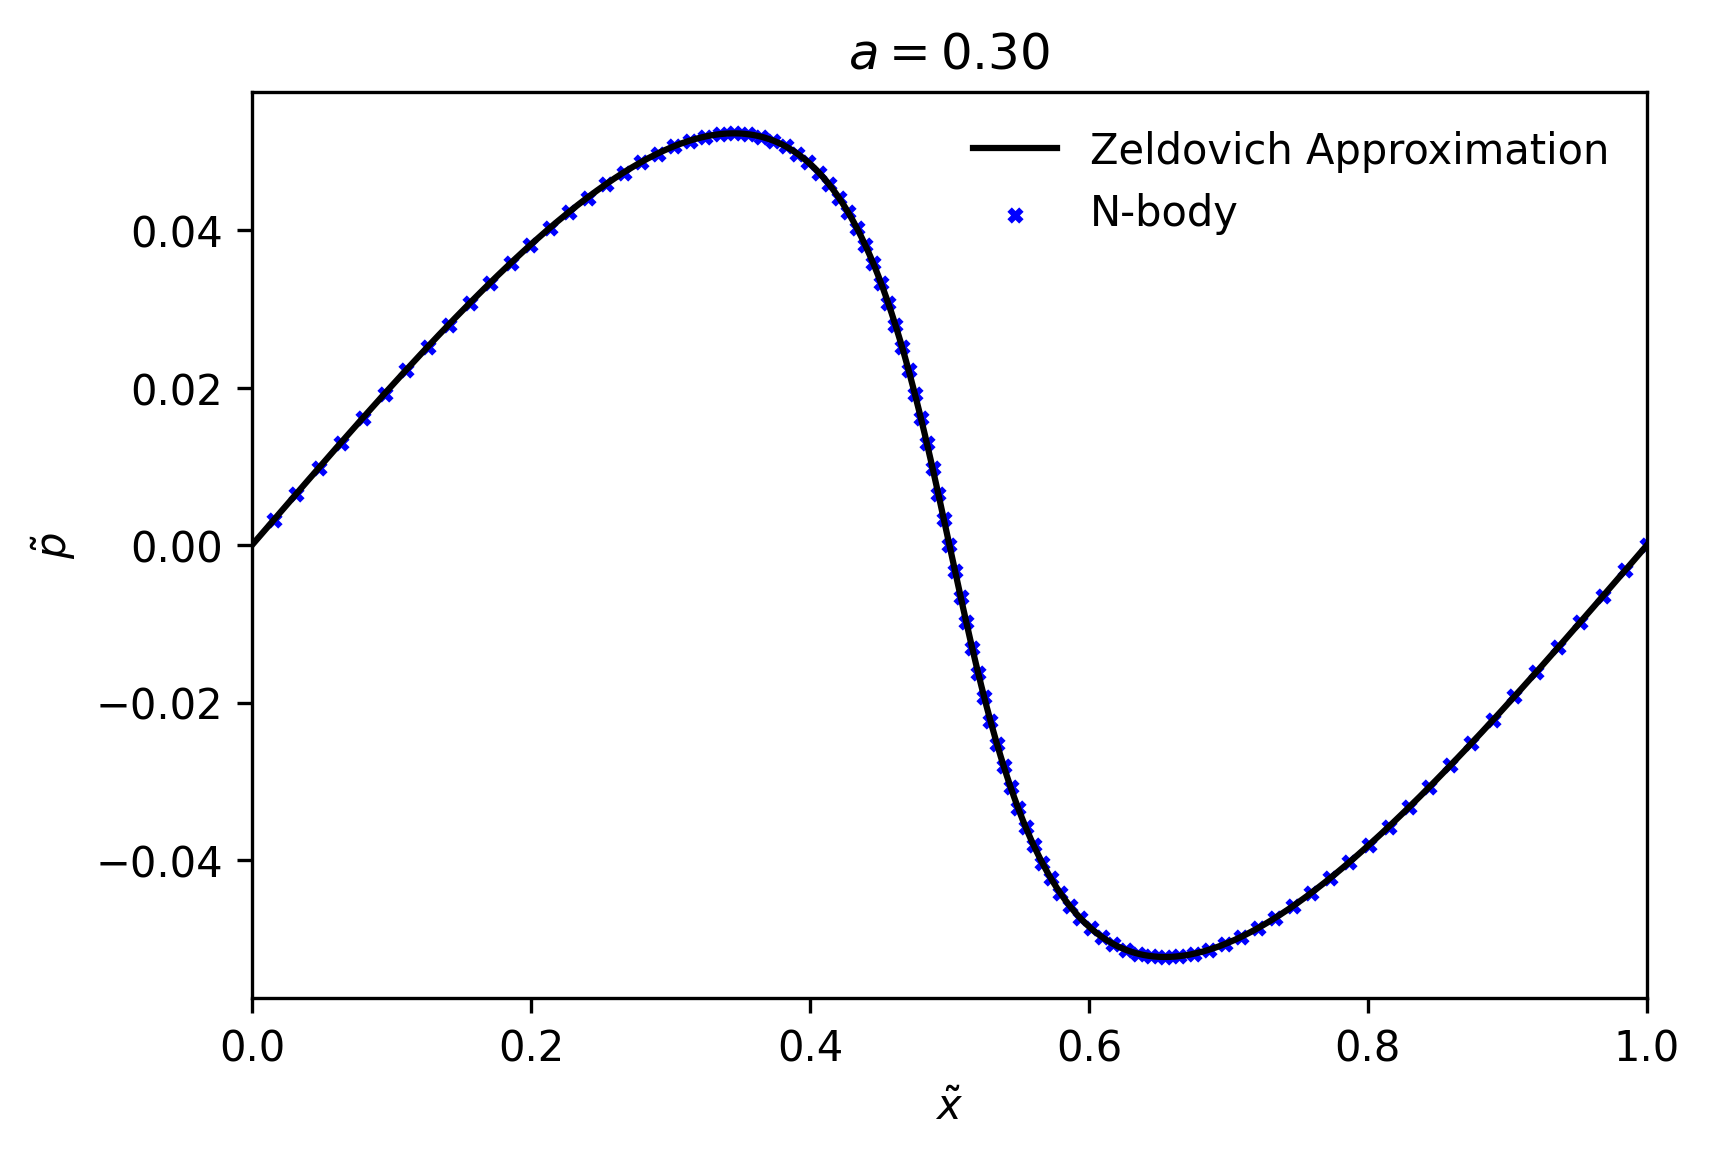

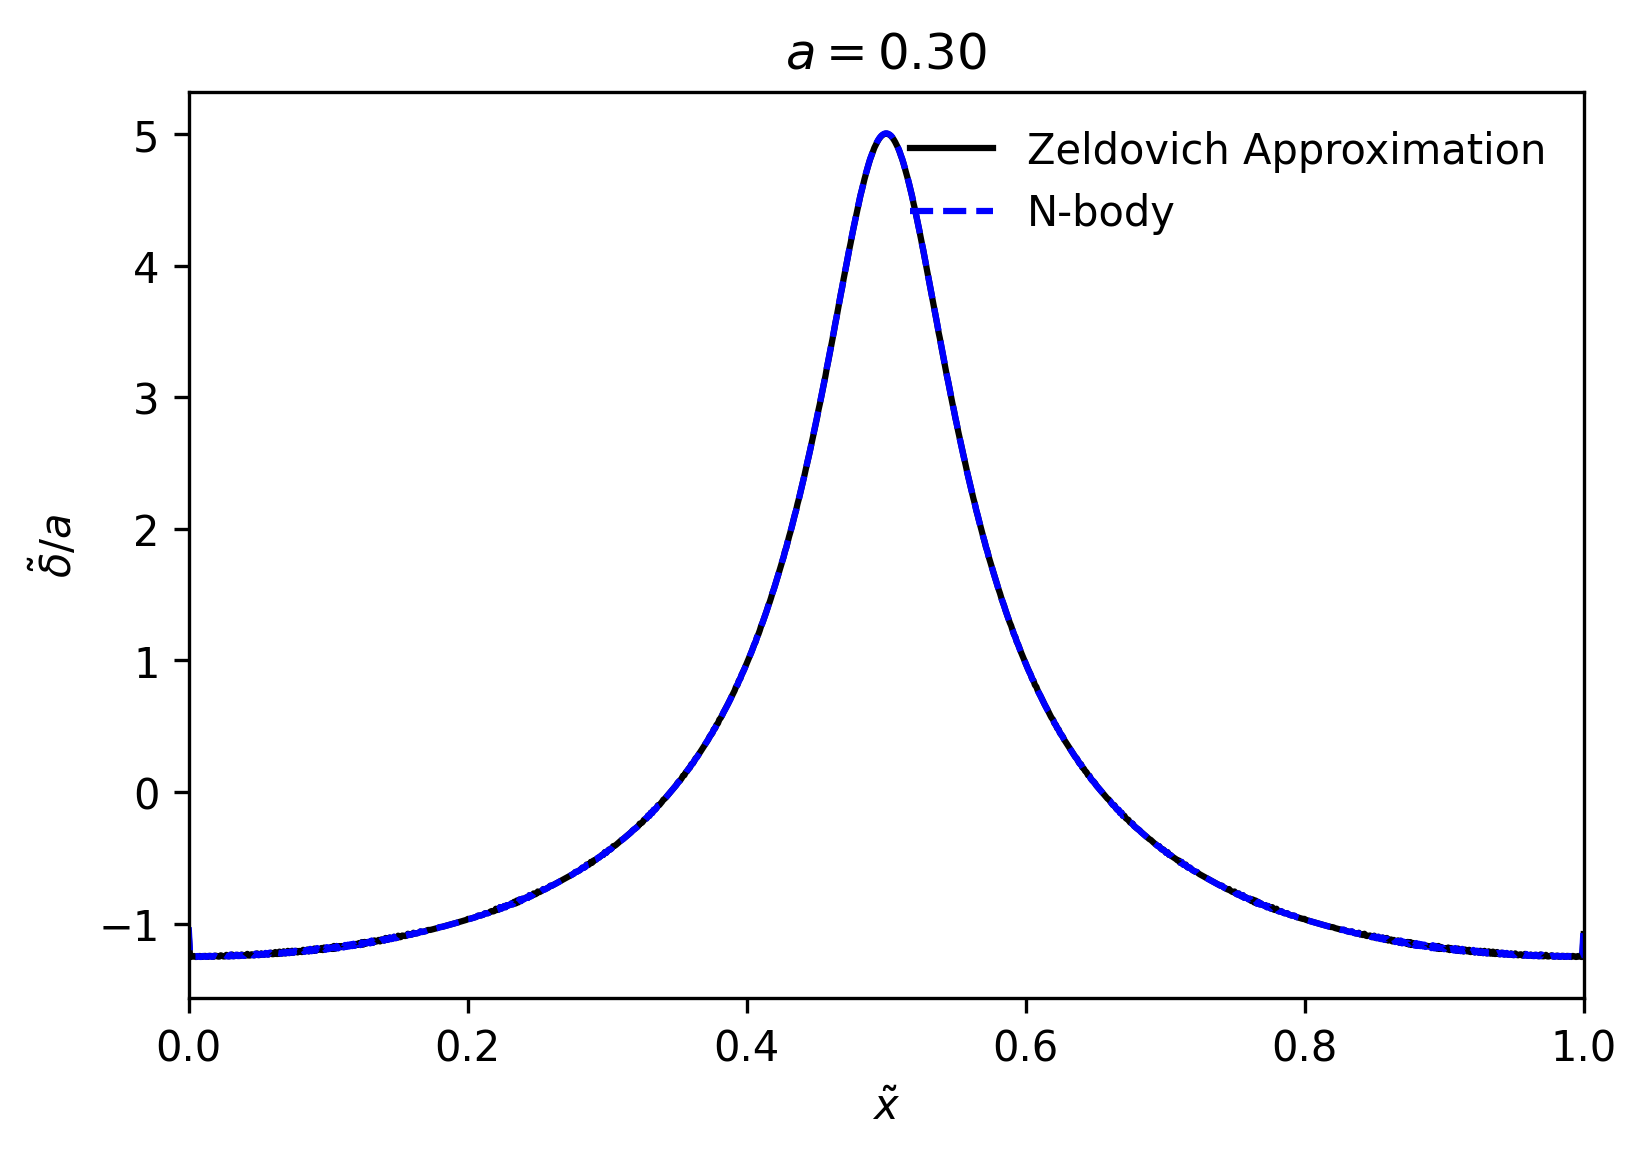

 33%|███▎      | 2996/9011 [00:03<00:05, 1120.61it/s]

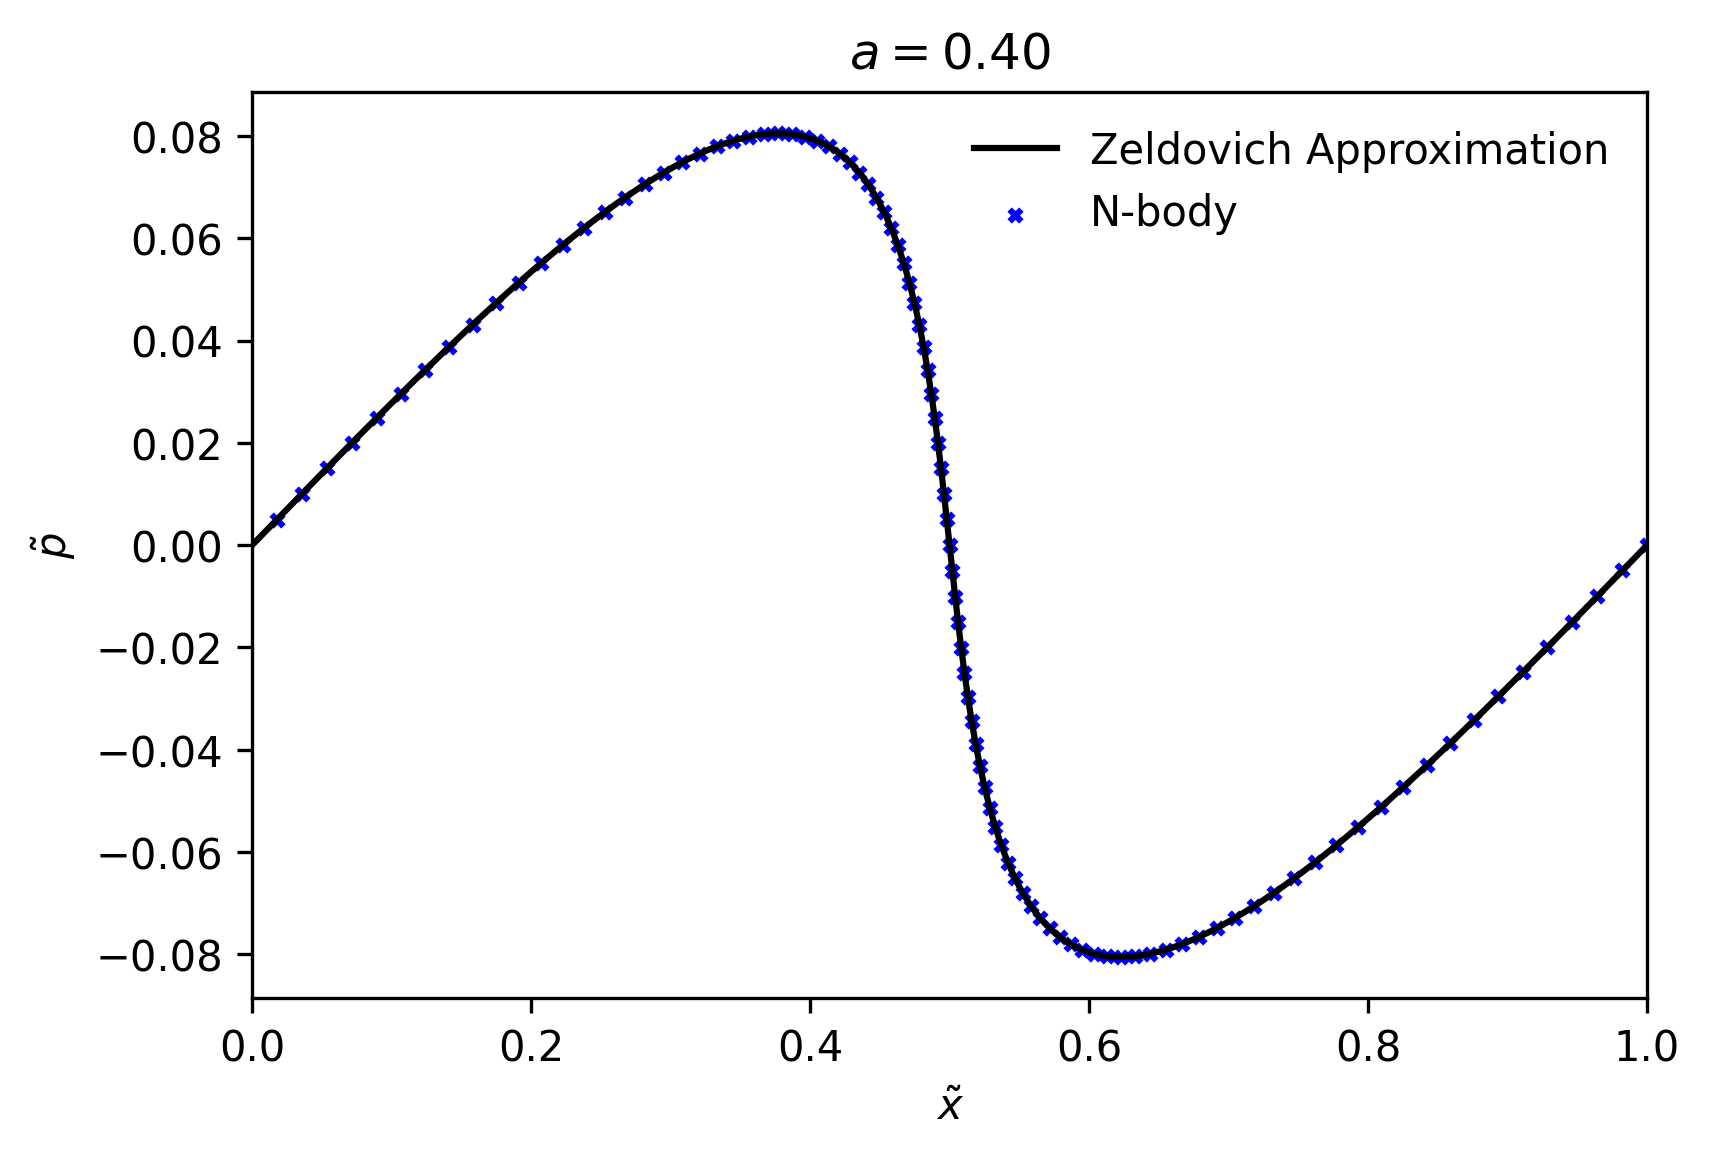

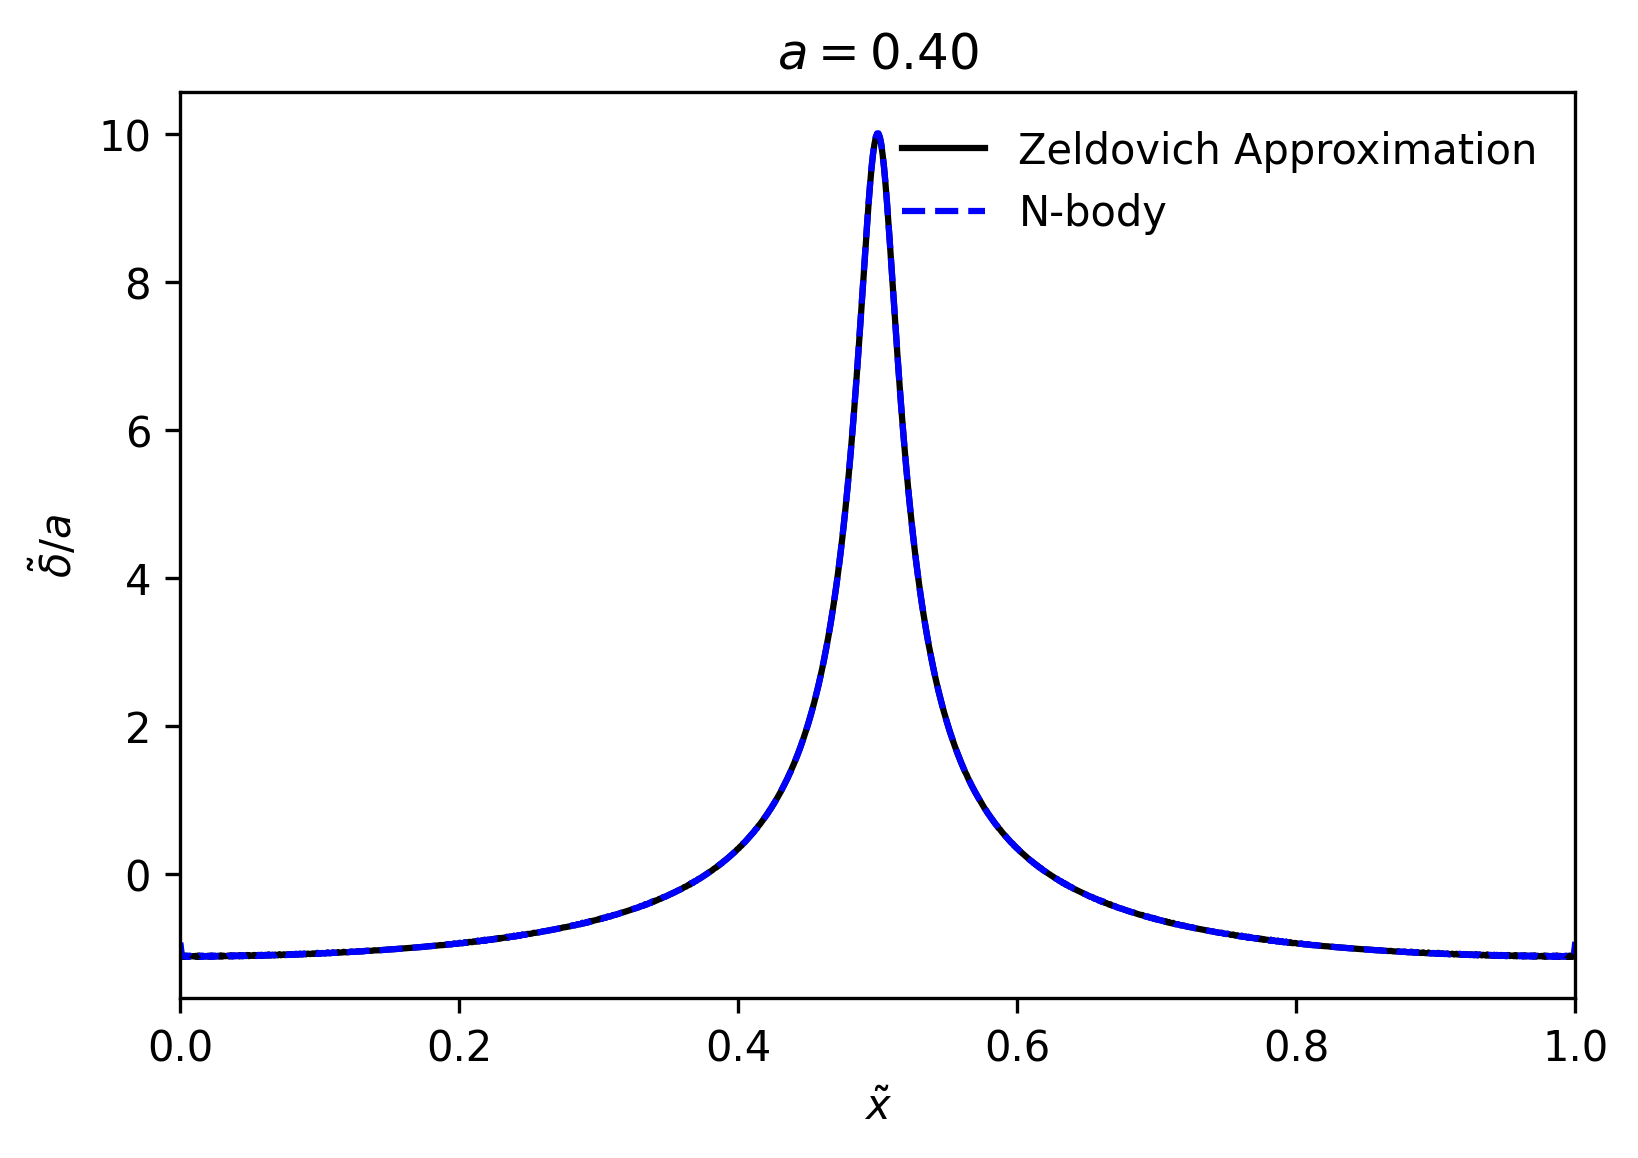

 44%|████▍     | 3993/9011 [00:05<00:04, 1107.67it/s]

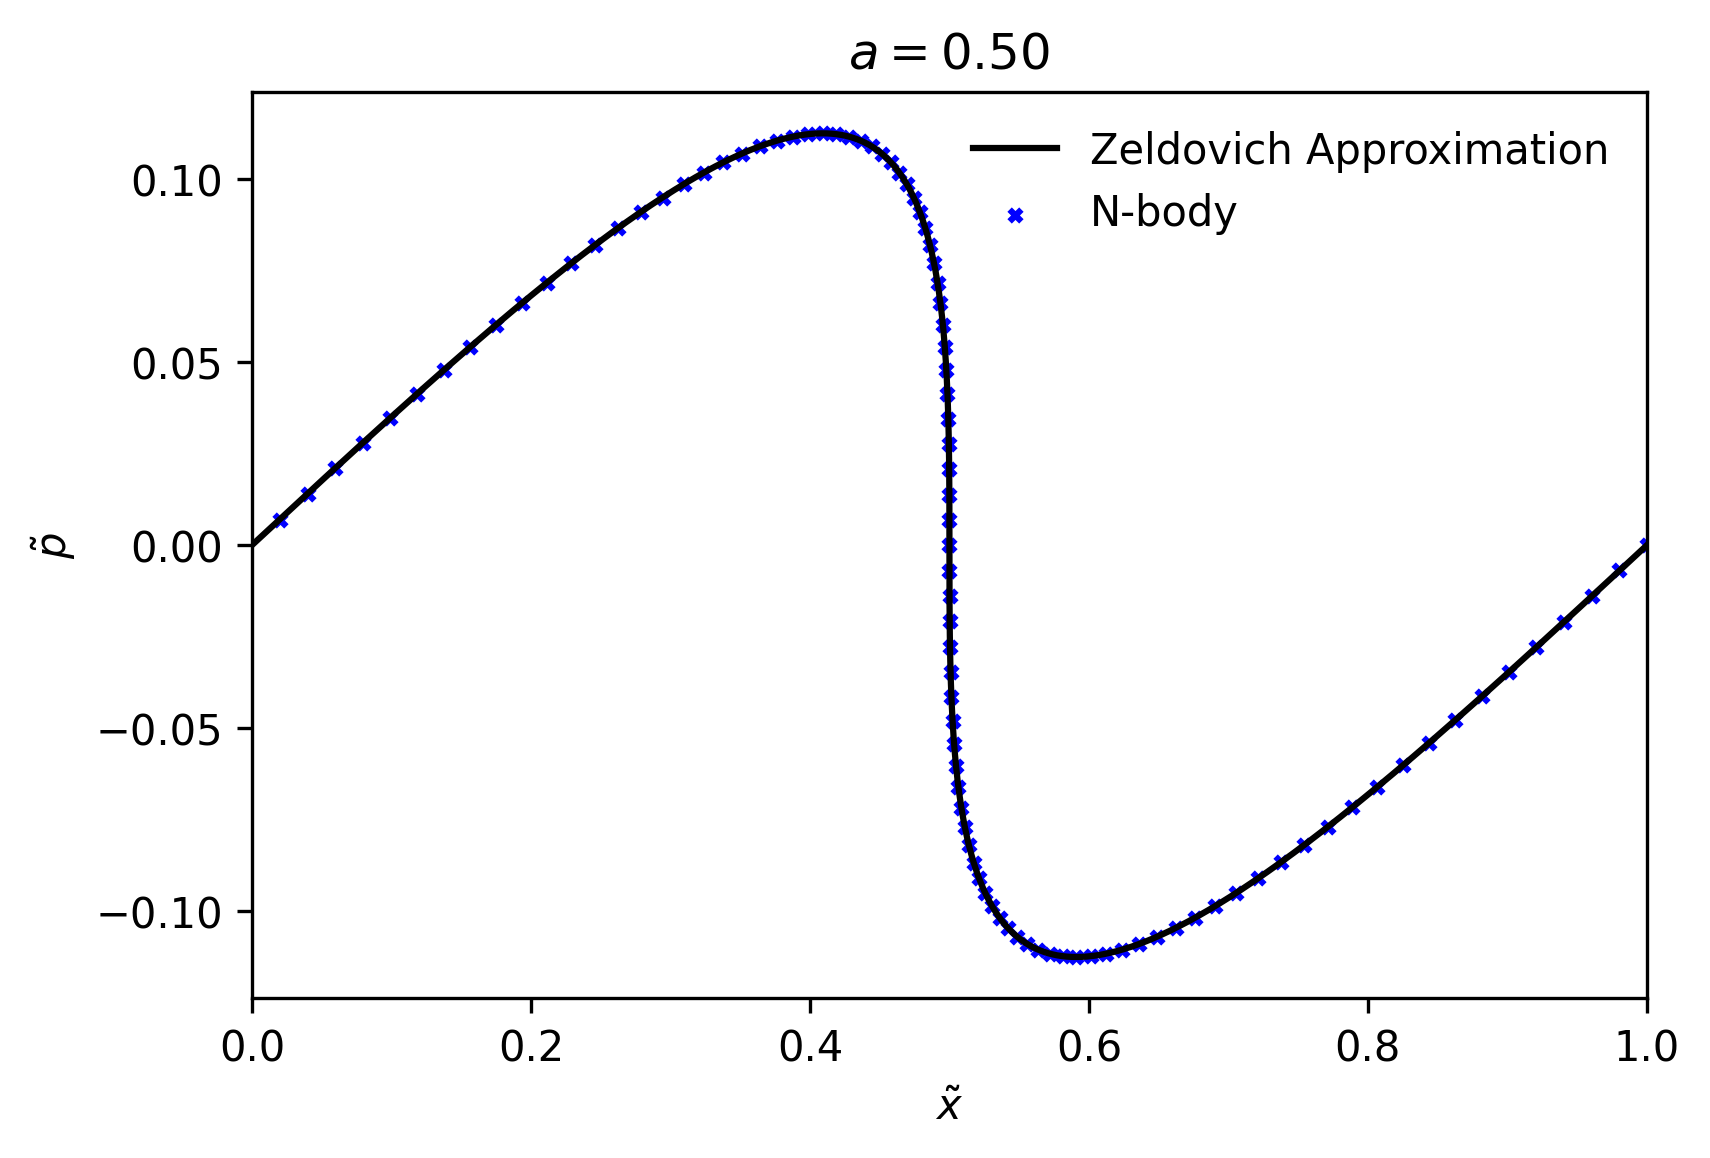

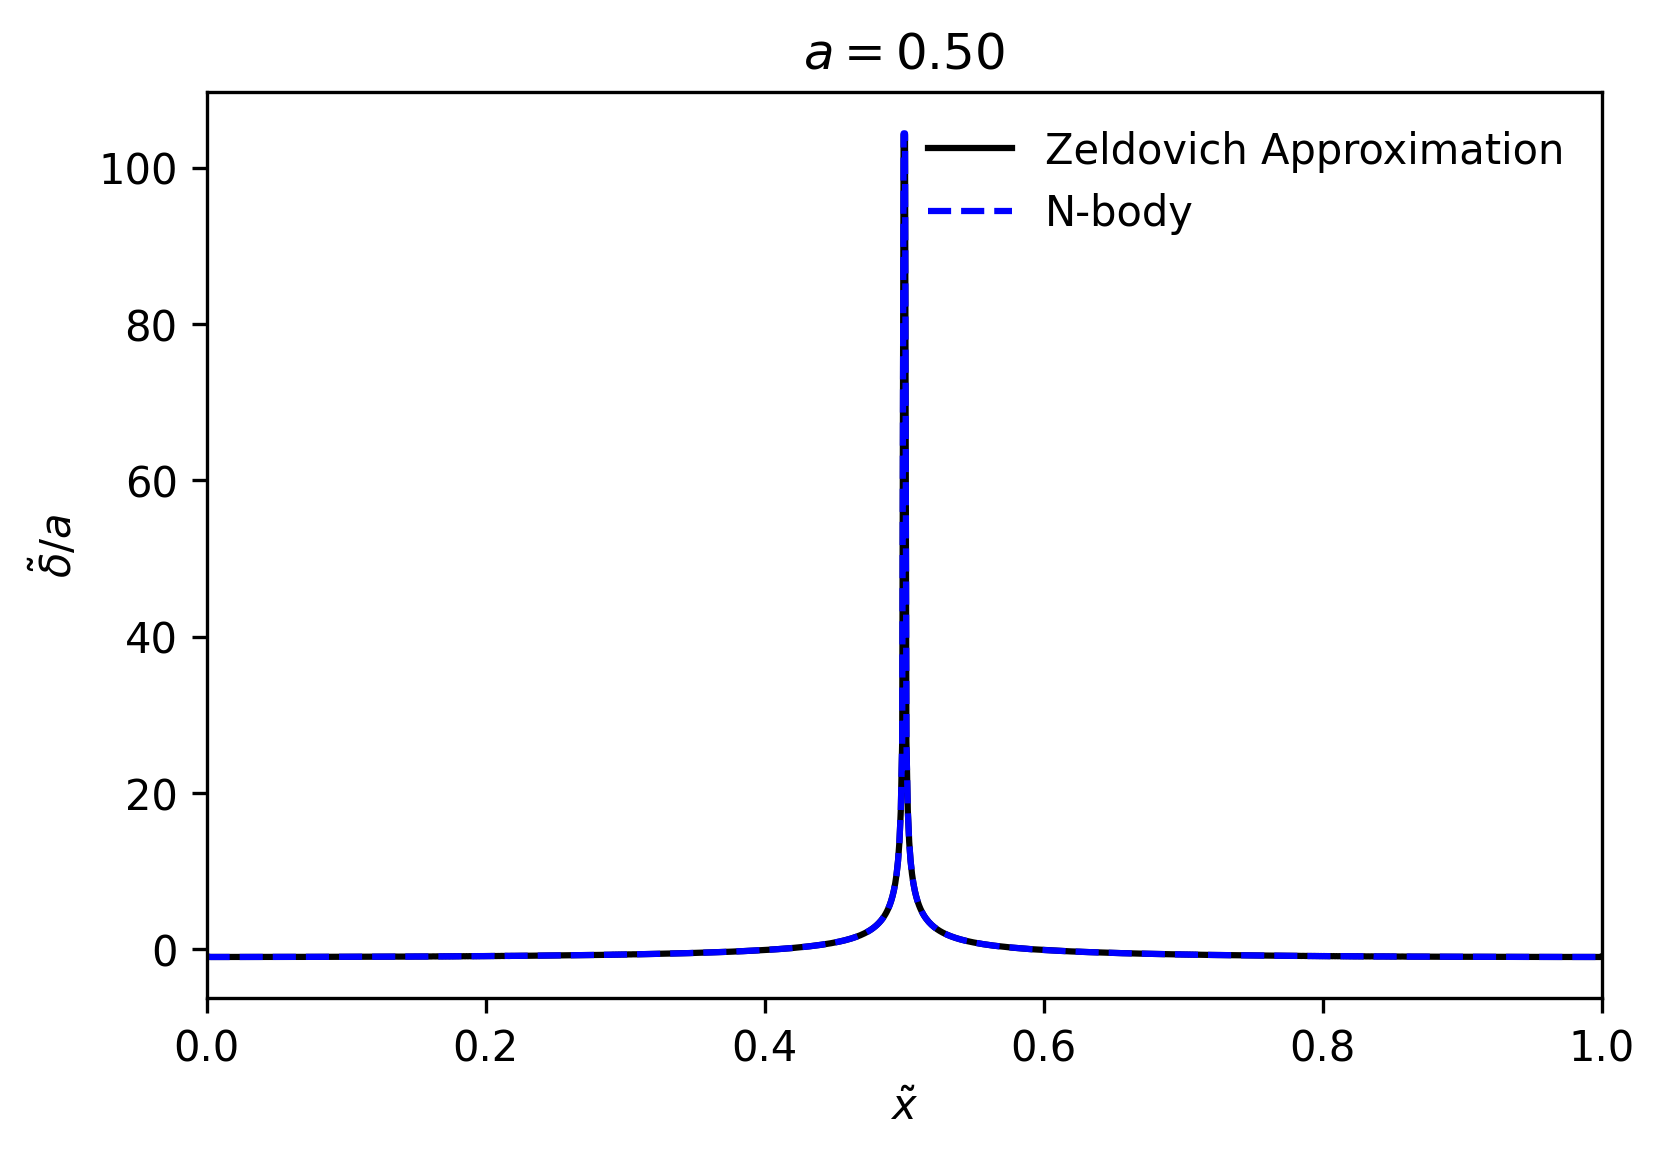

 55%|█████▌    | 4984/9011 [00:06<00:03, 1109.05it/s]

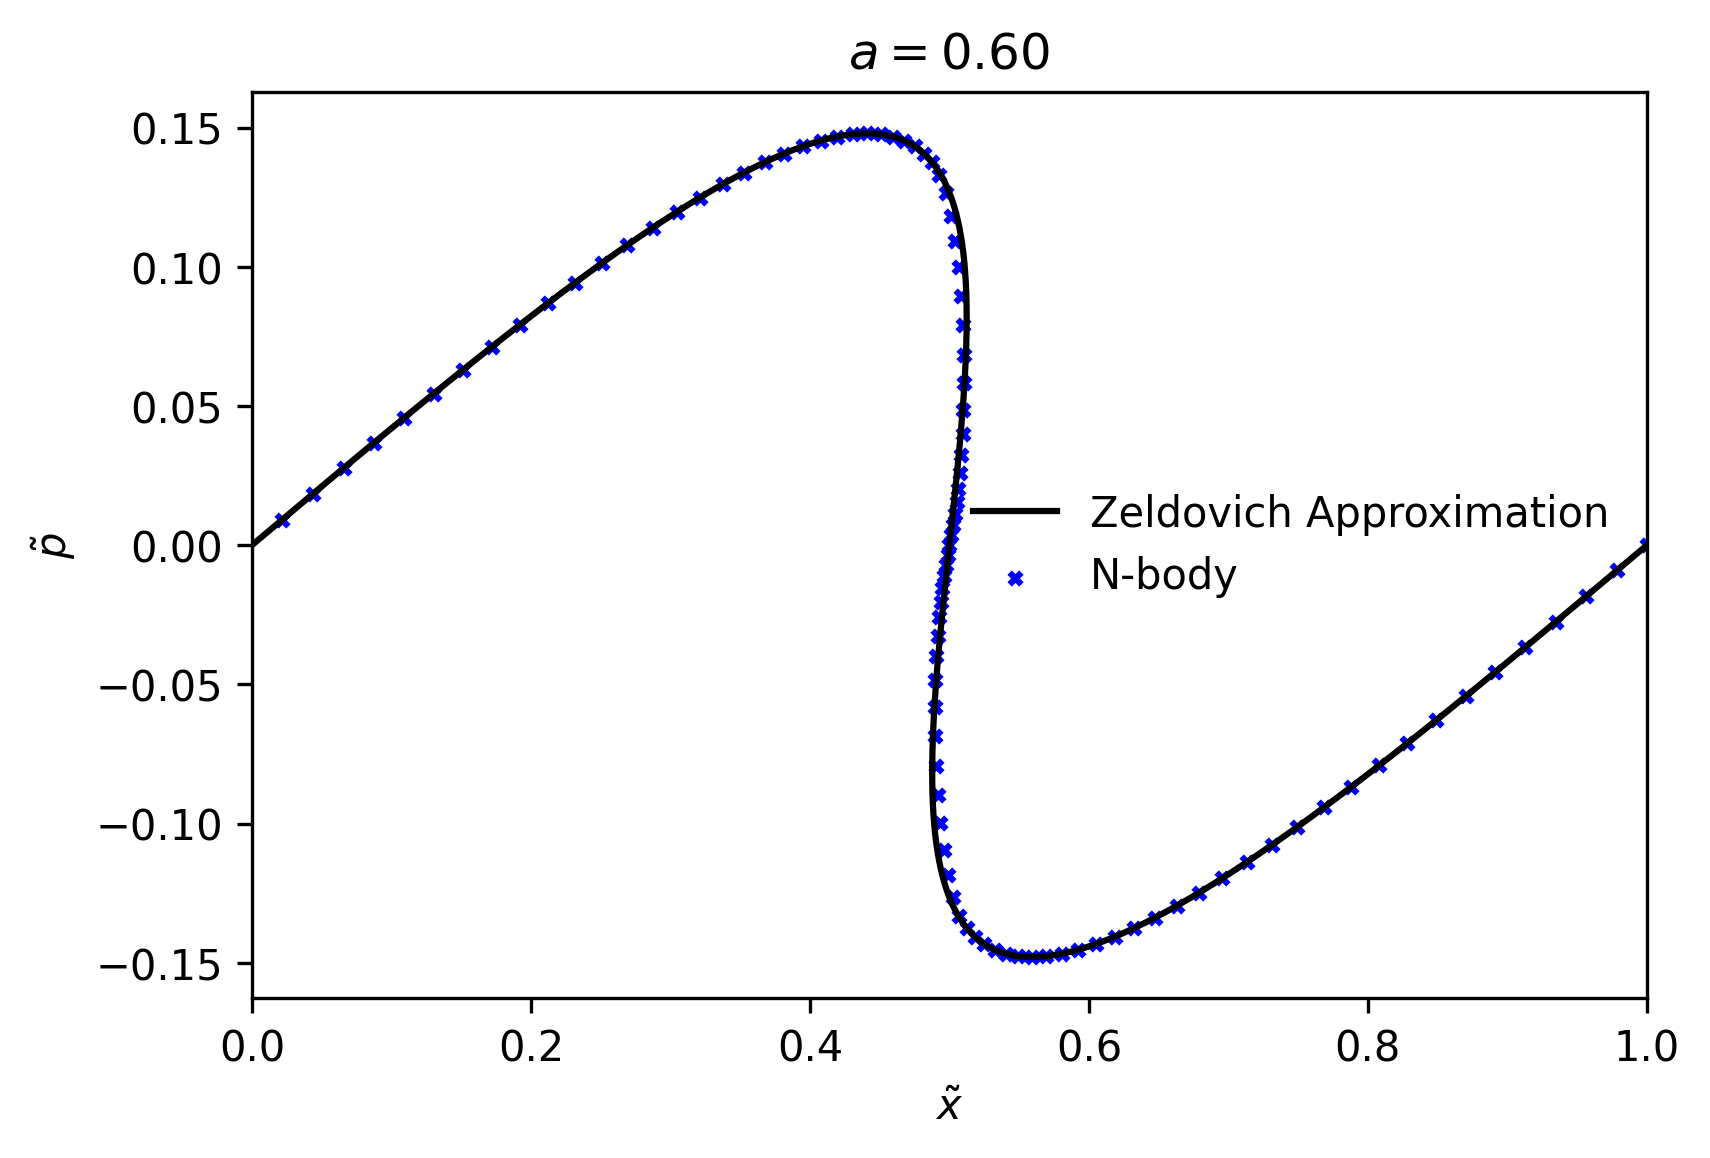

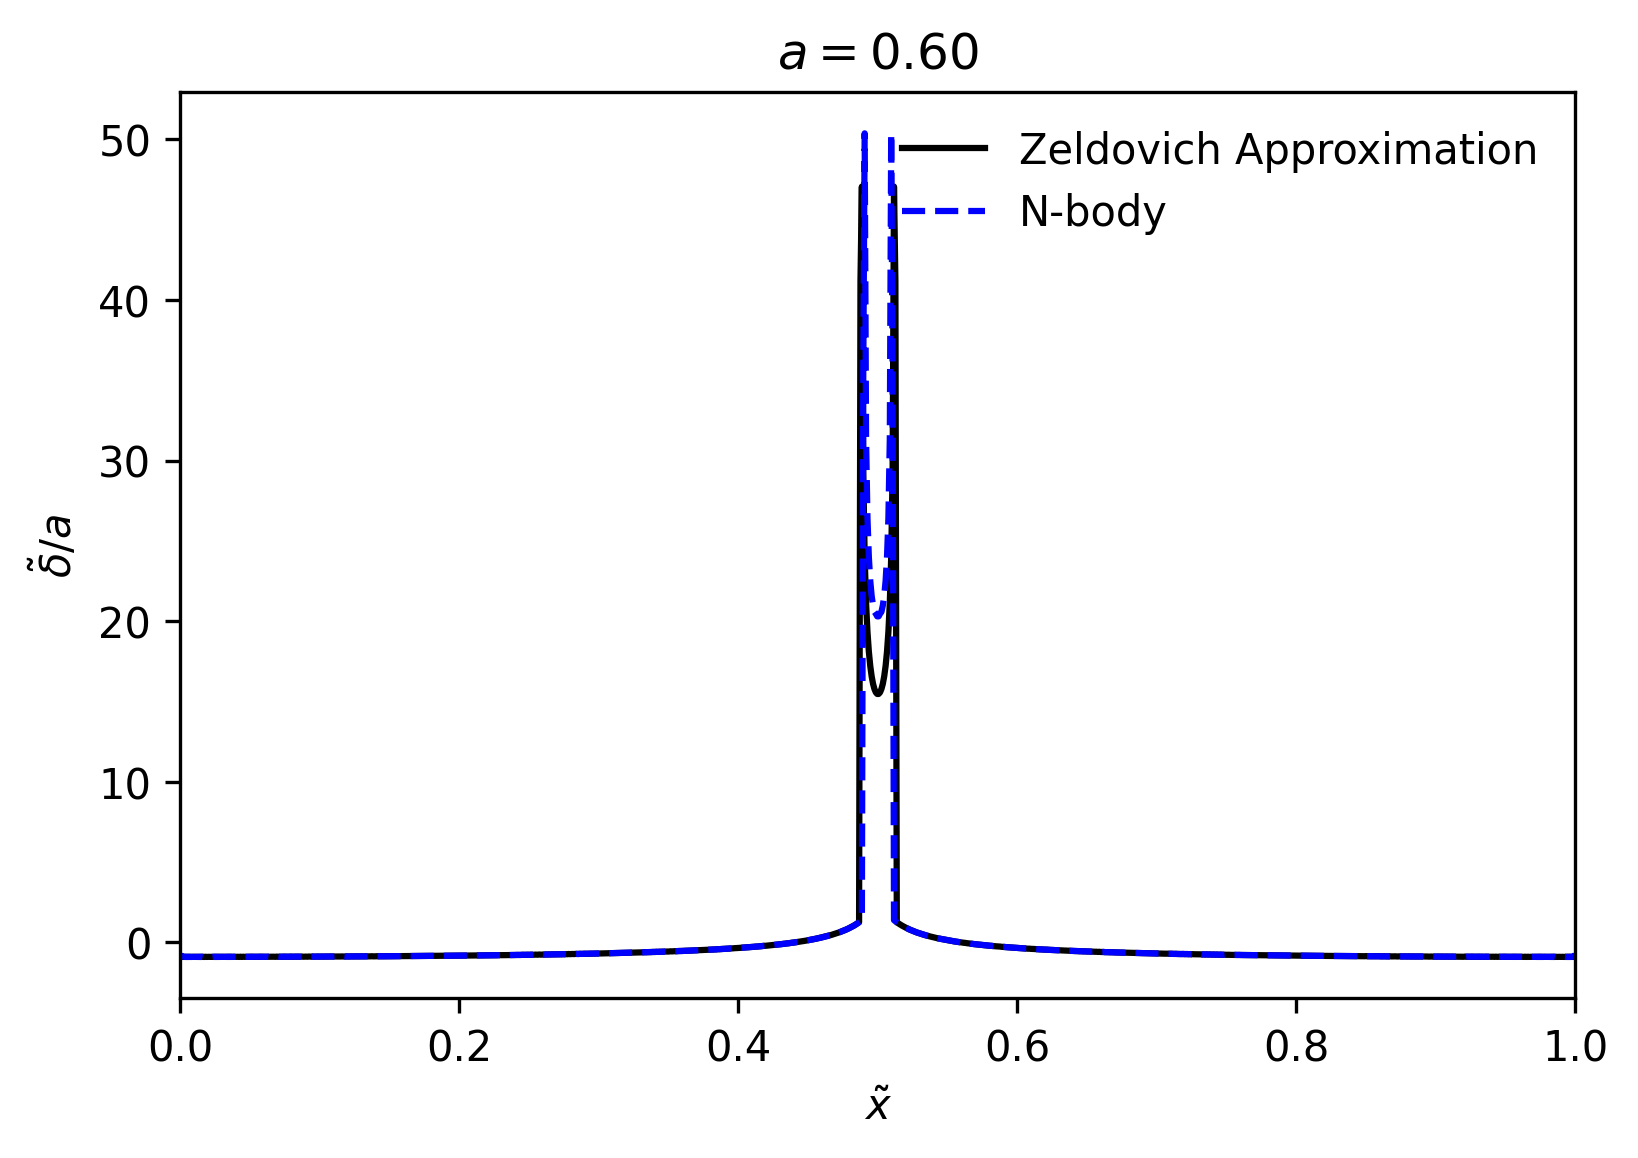

 66%|██████▋   | 5977/9011 [00:07<00:02, 1096.19it/s]

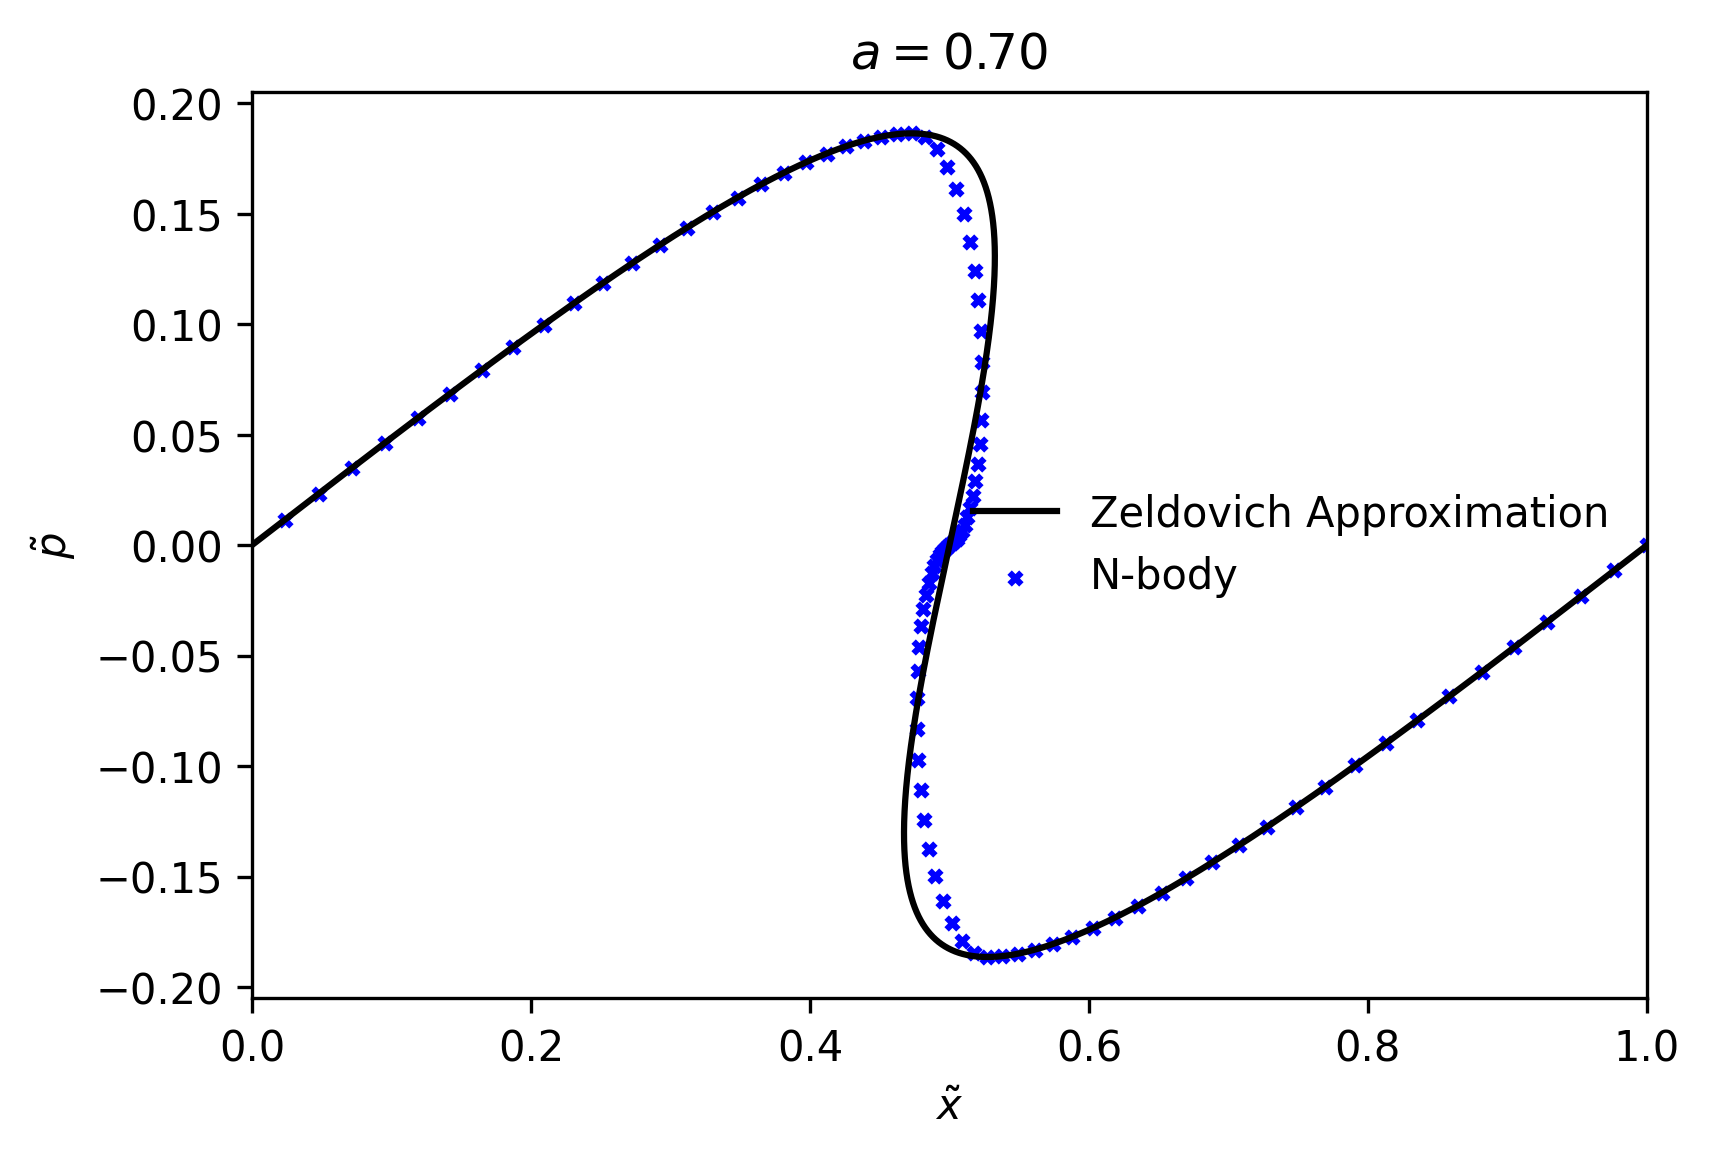

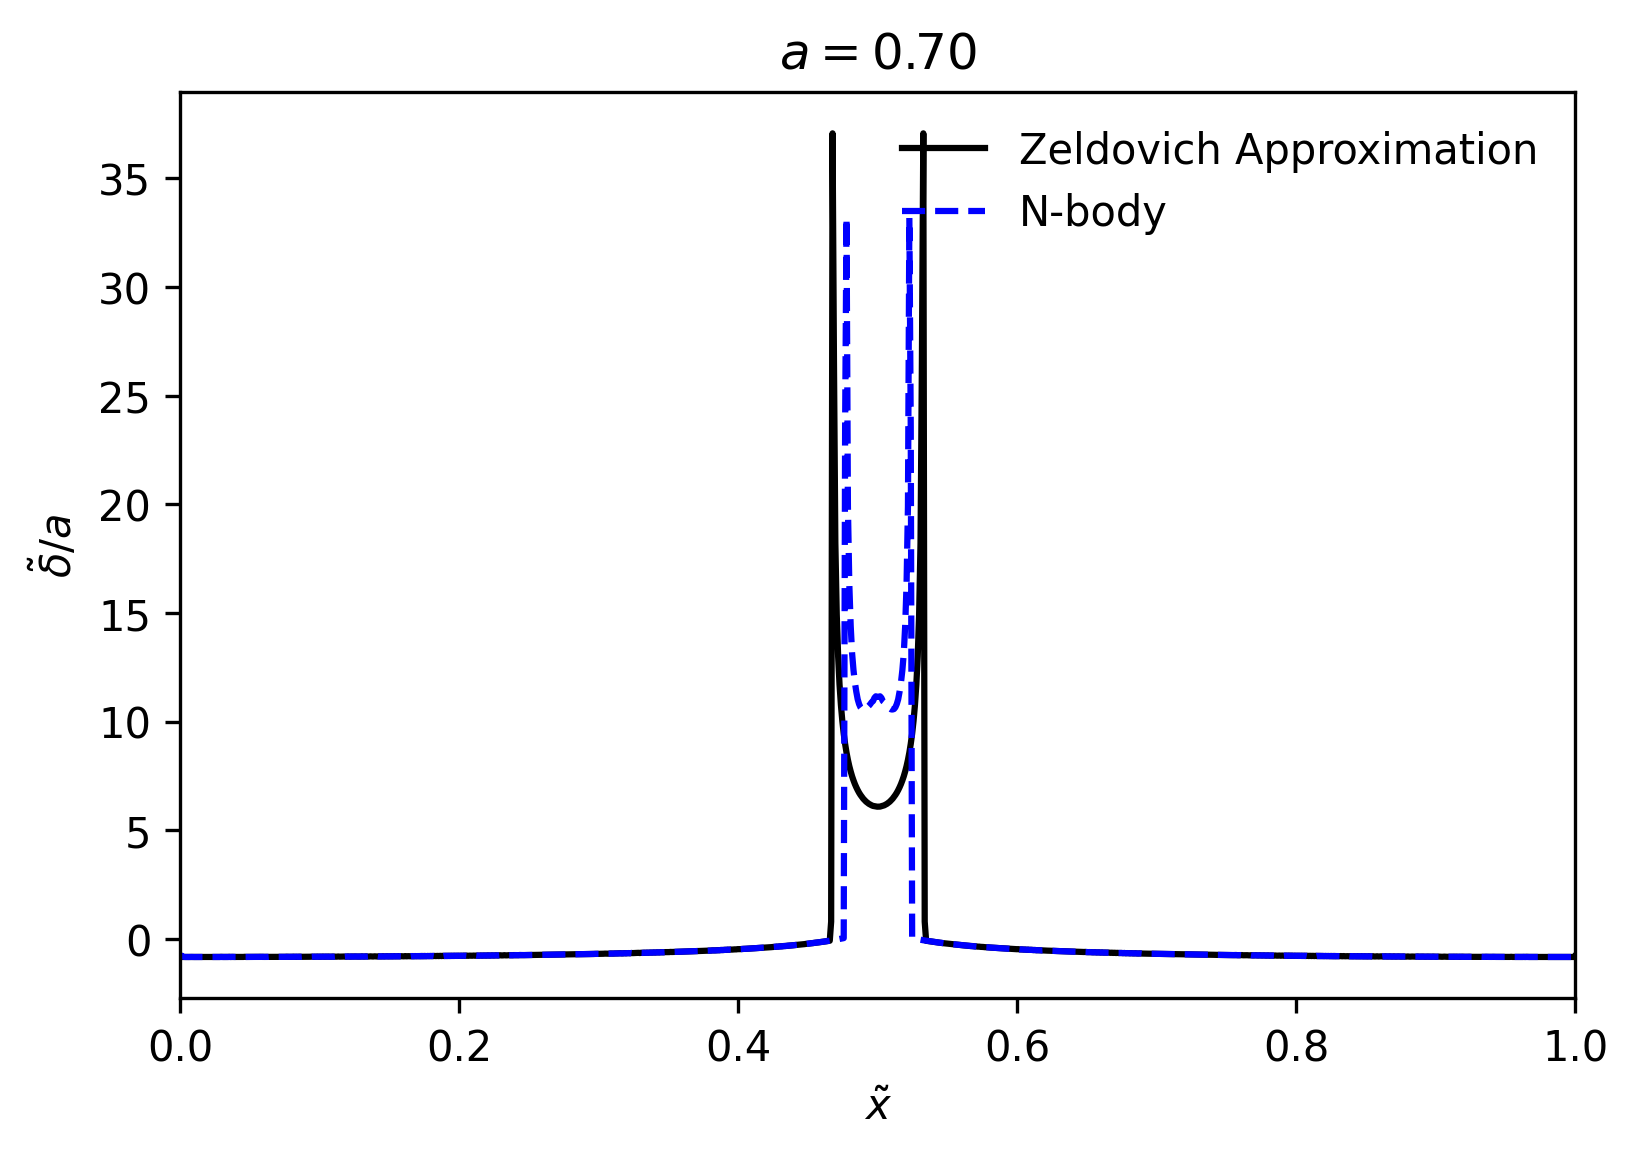

 77%|███████▋  | 6959/9011 [00:09<00:01, 1069.14it/s]

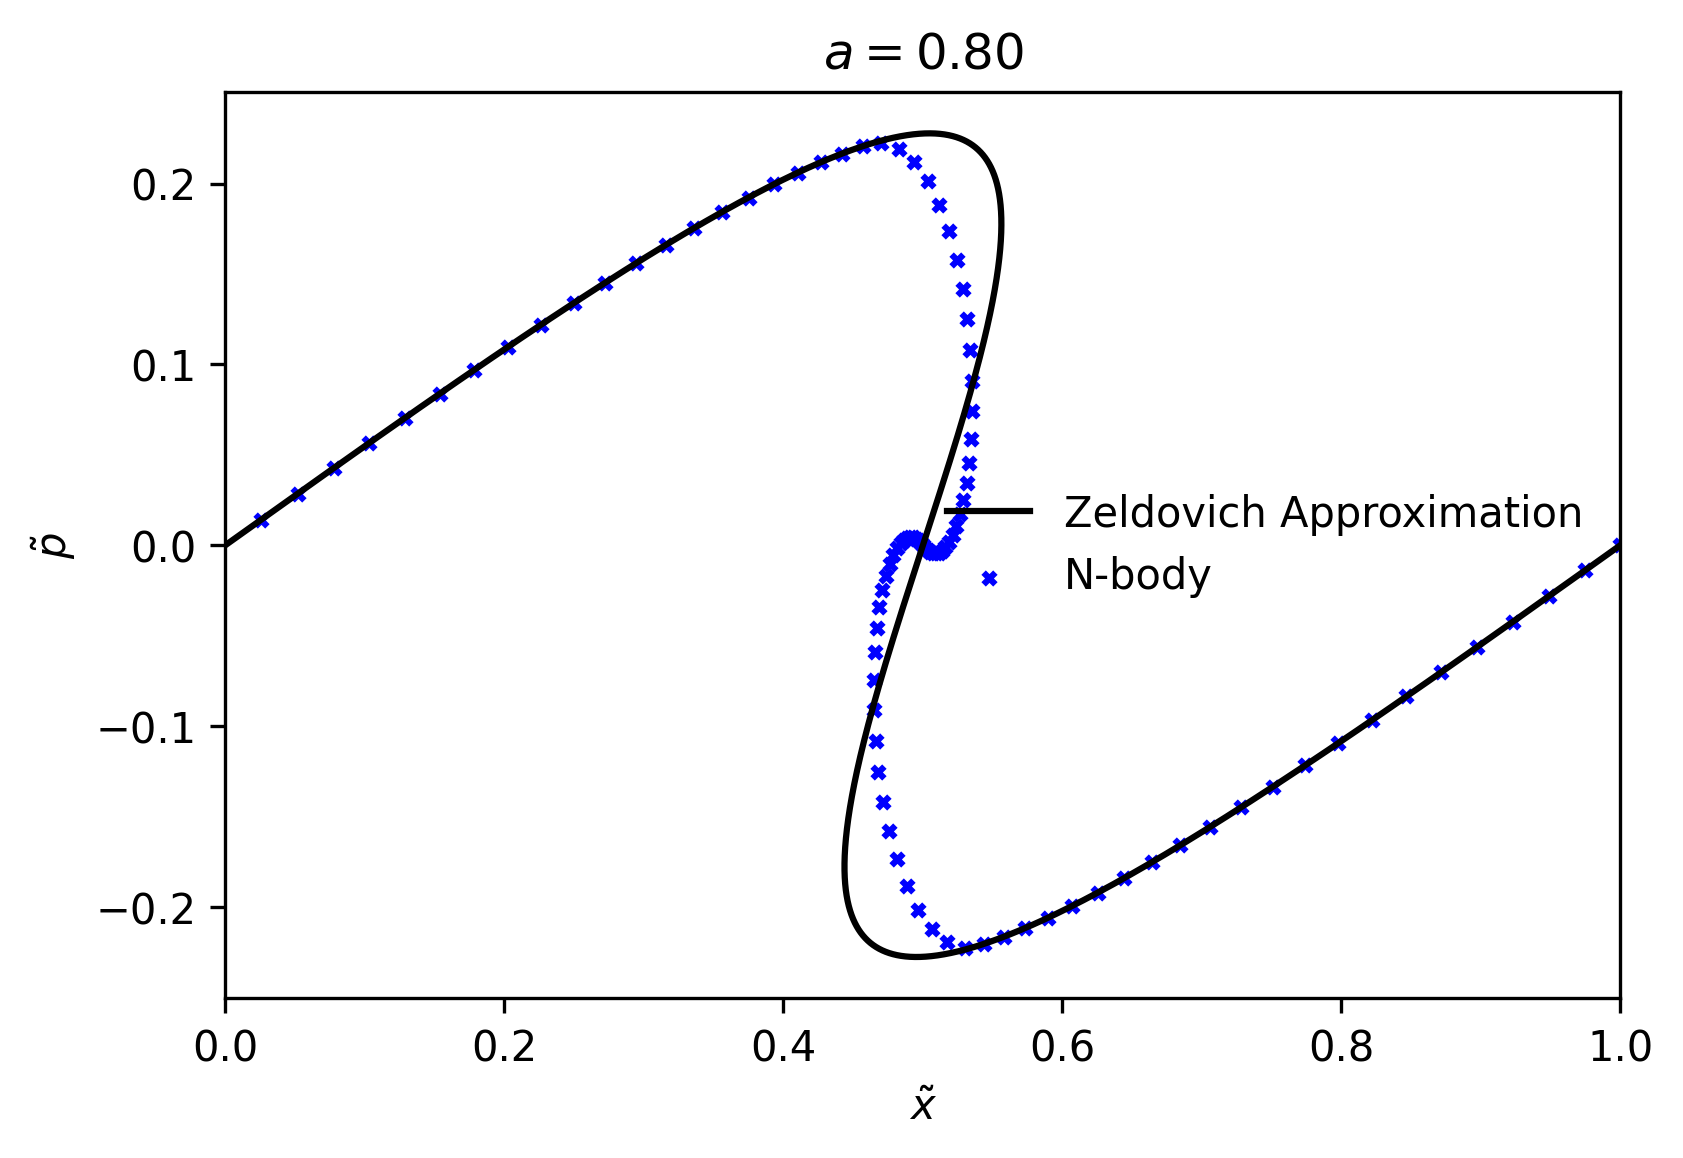

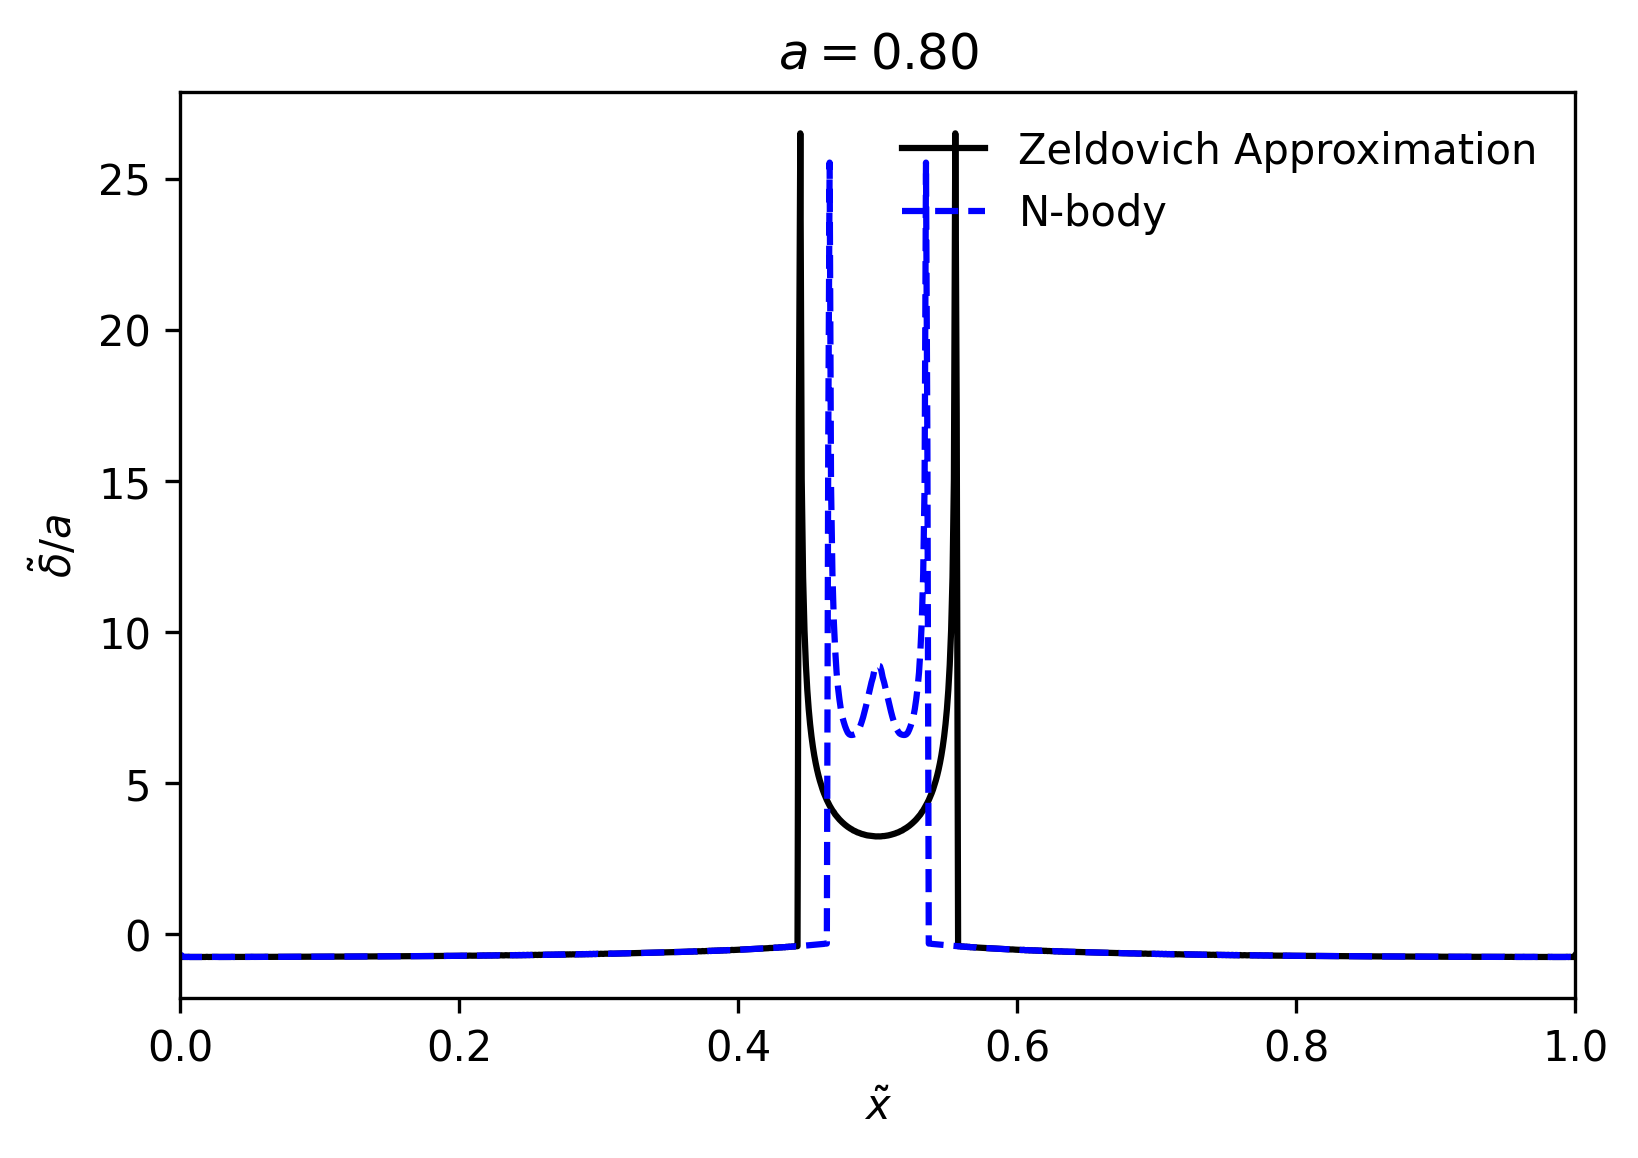

 88%|████████▊ | 7940/9011 [00:10<00:00, 1087.87it/s]

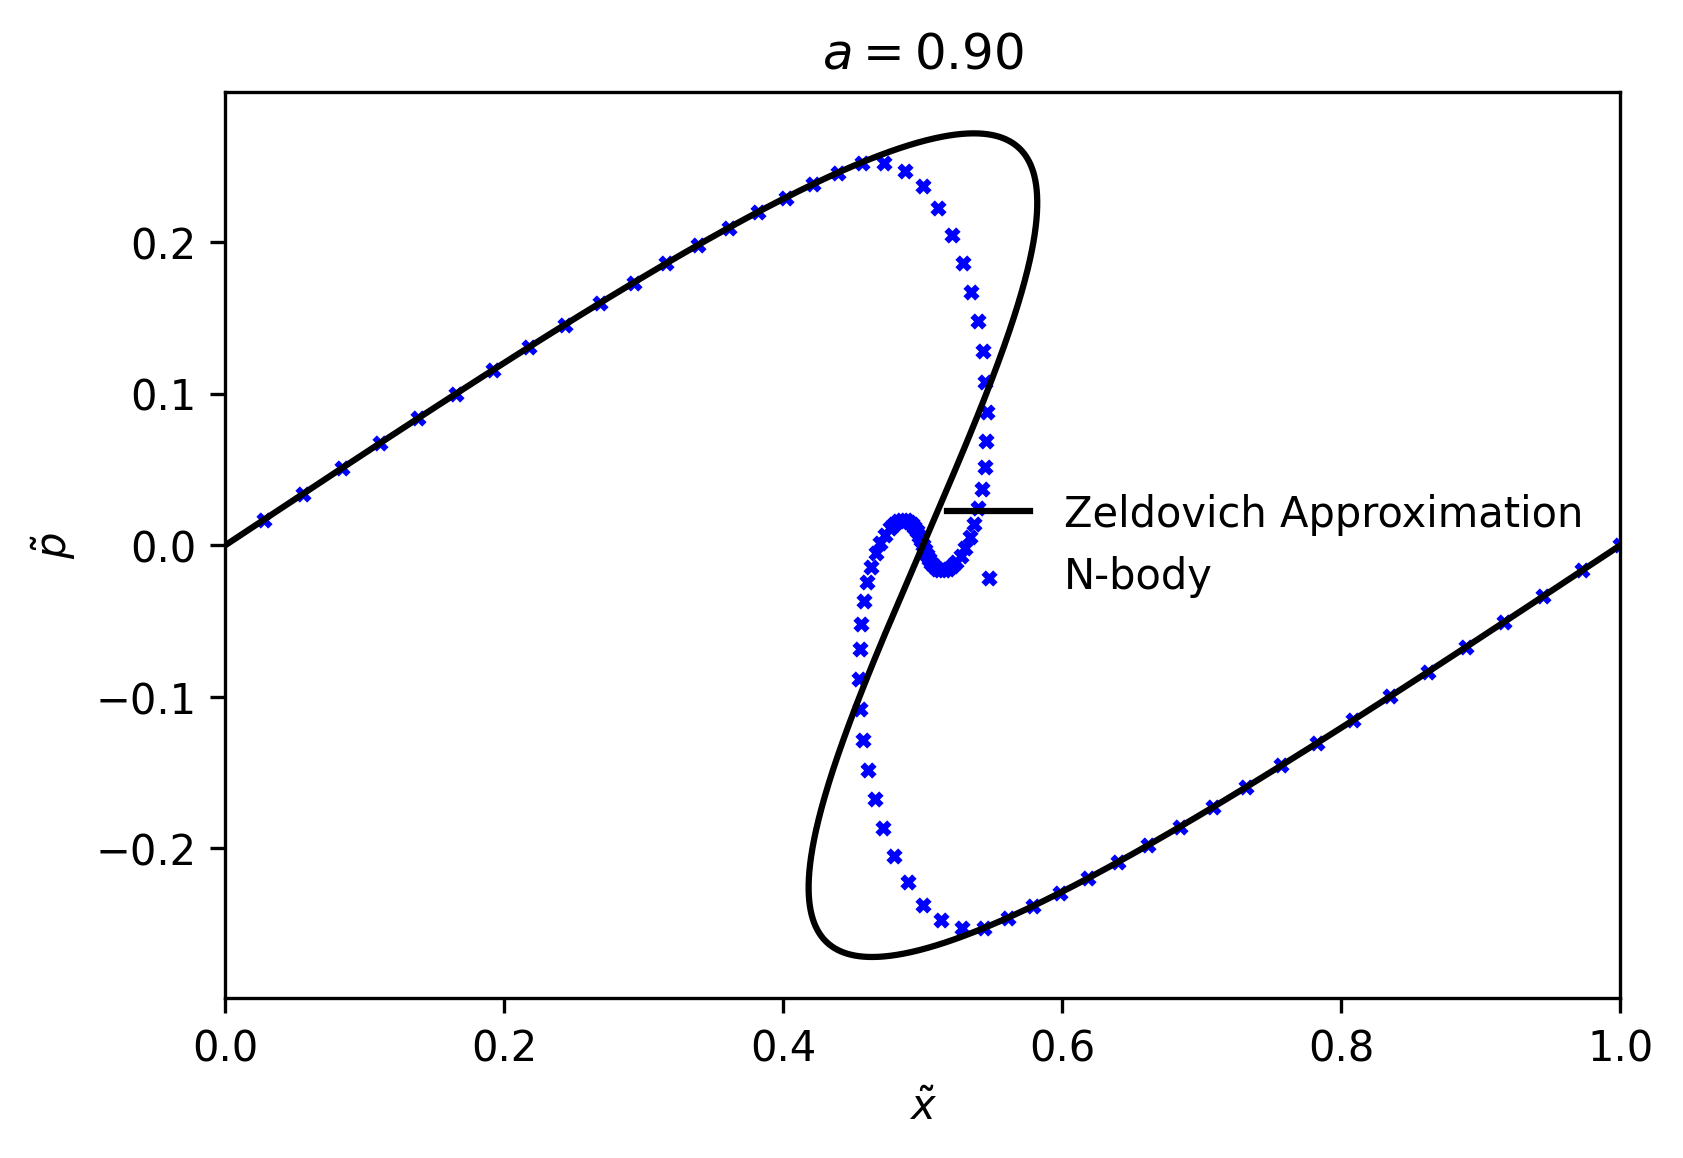

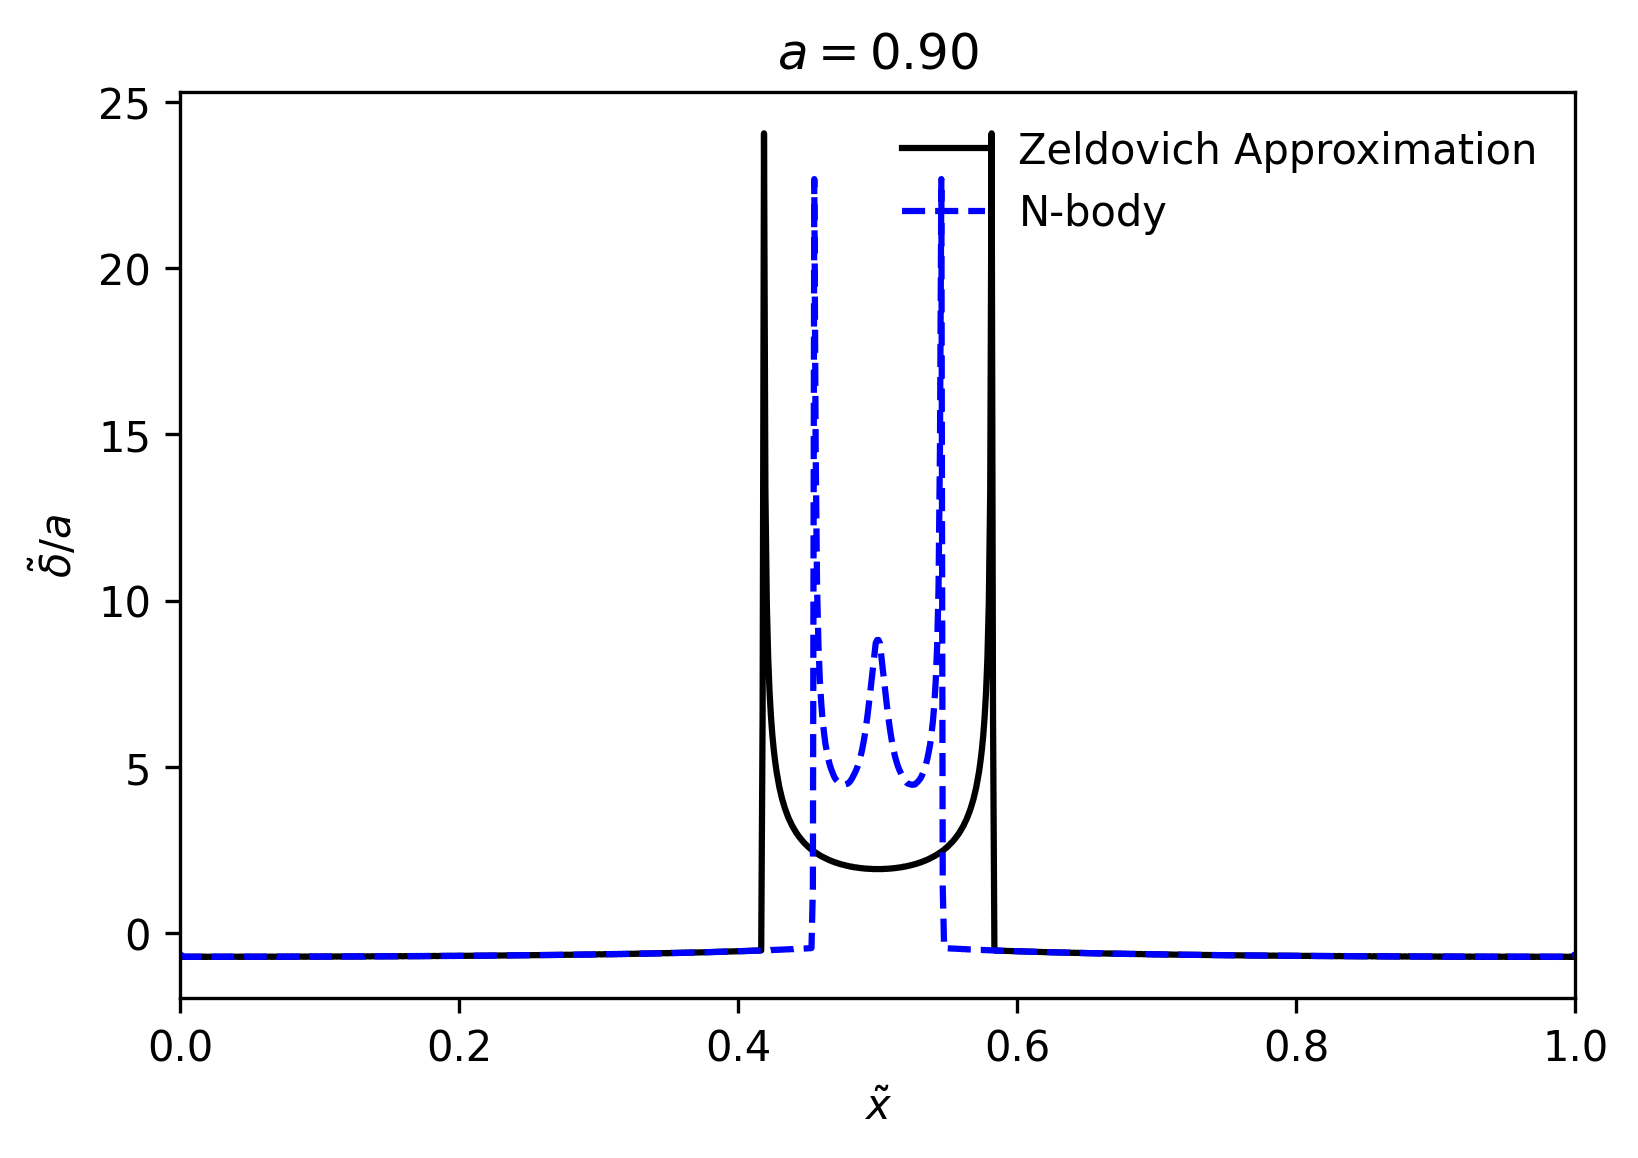

 99%|█████████▉| 8923/9011 [00:11<00:00, 1095.01it/s]

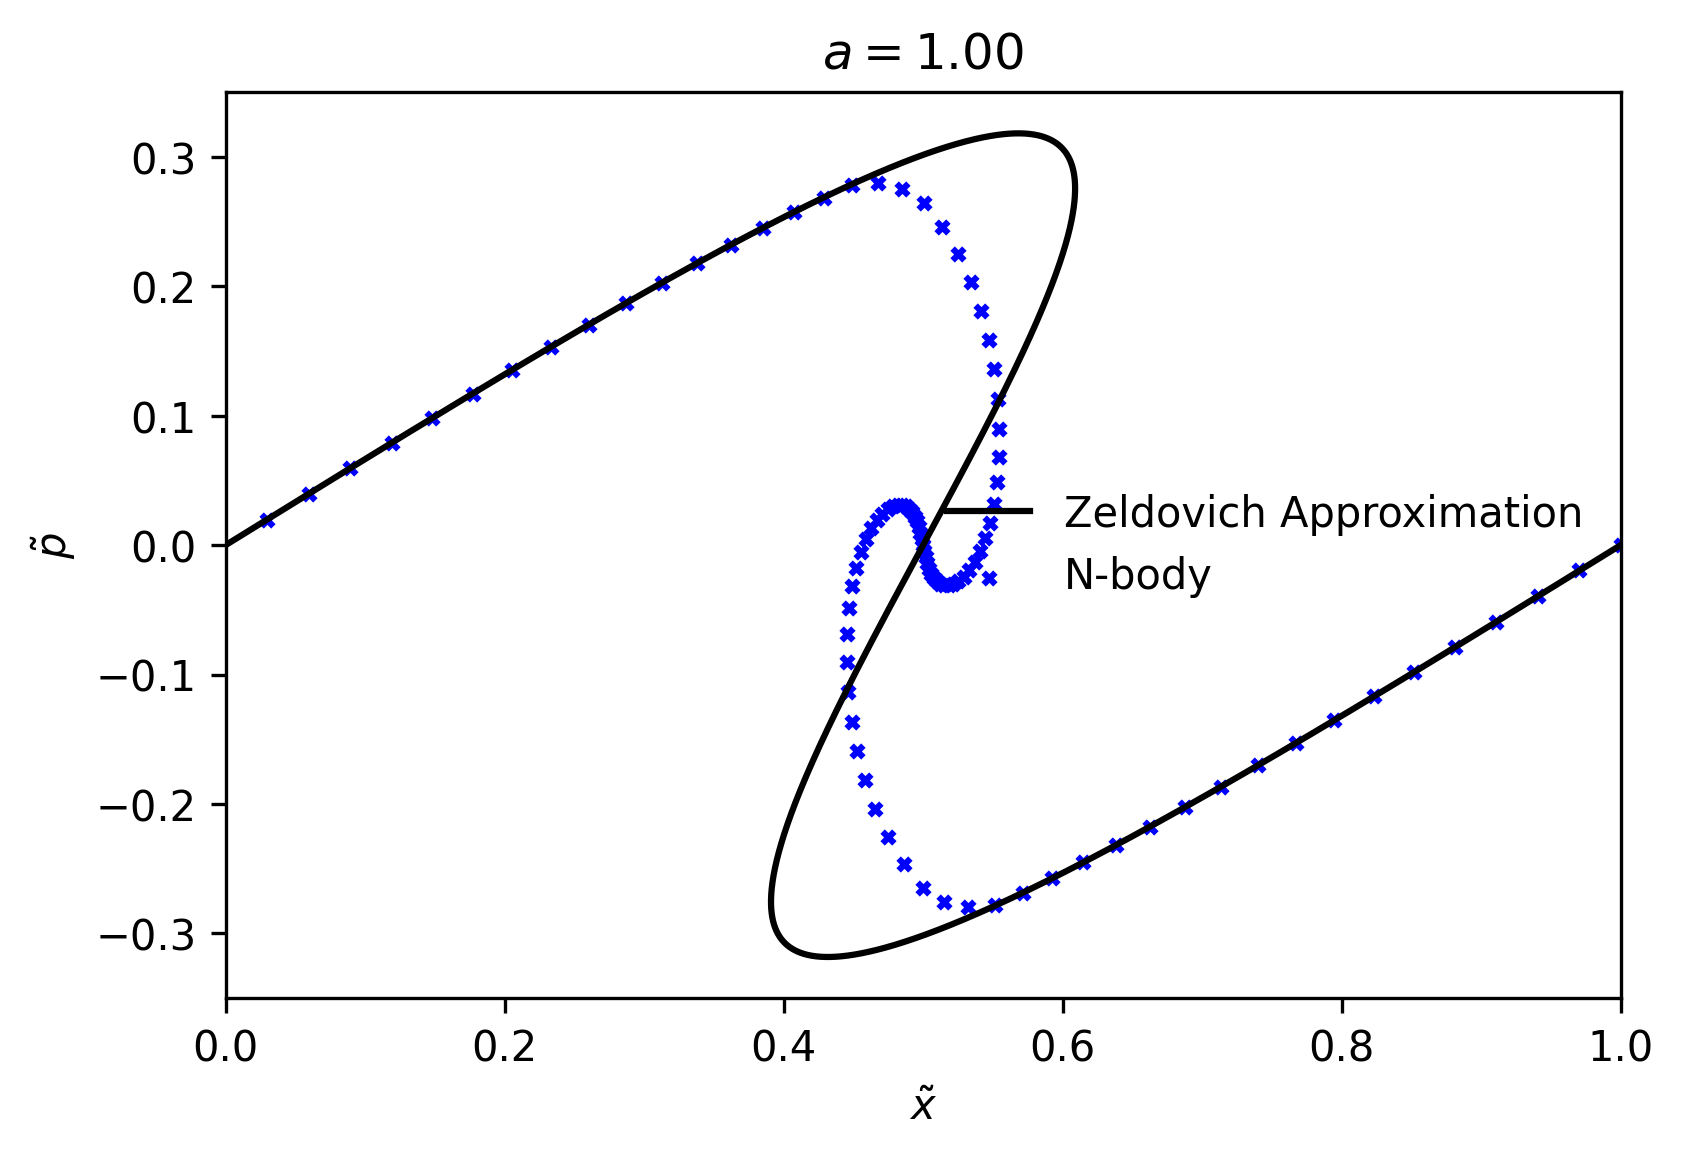

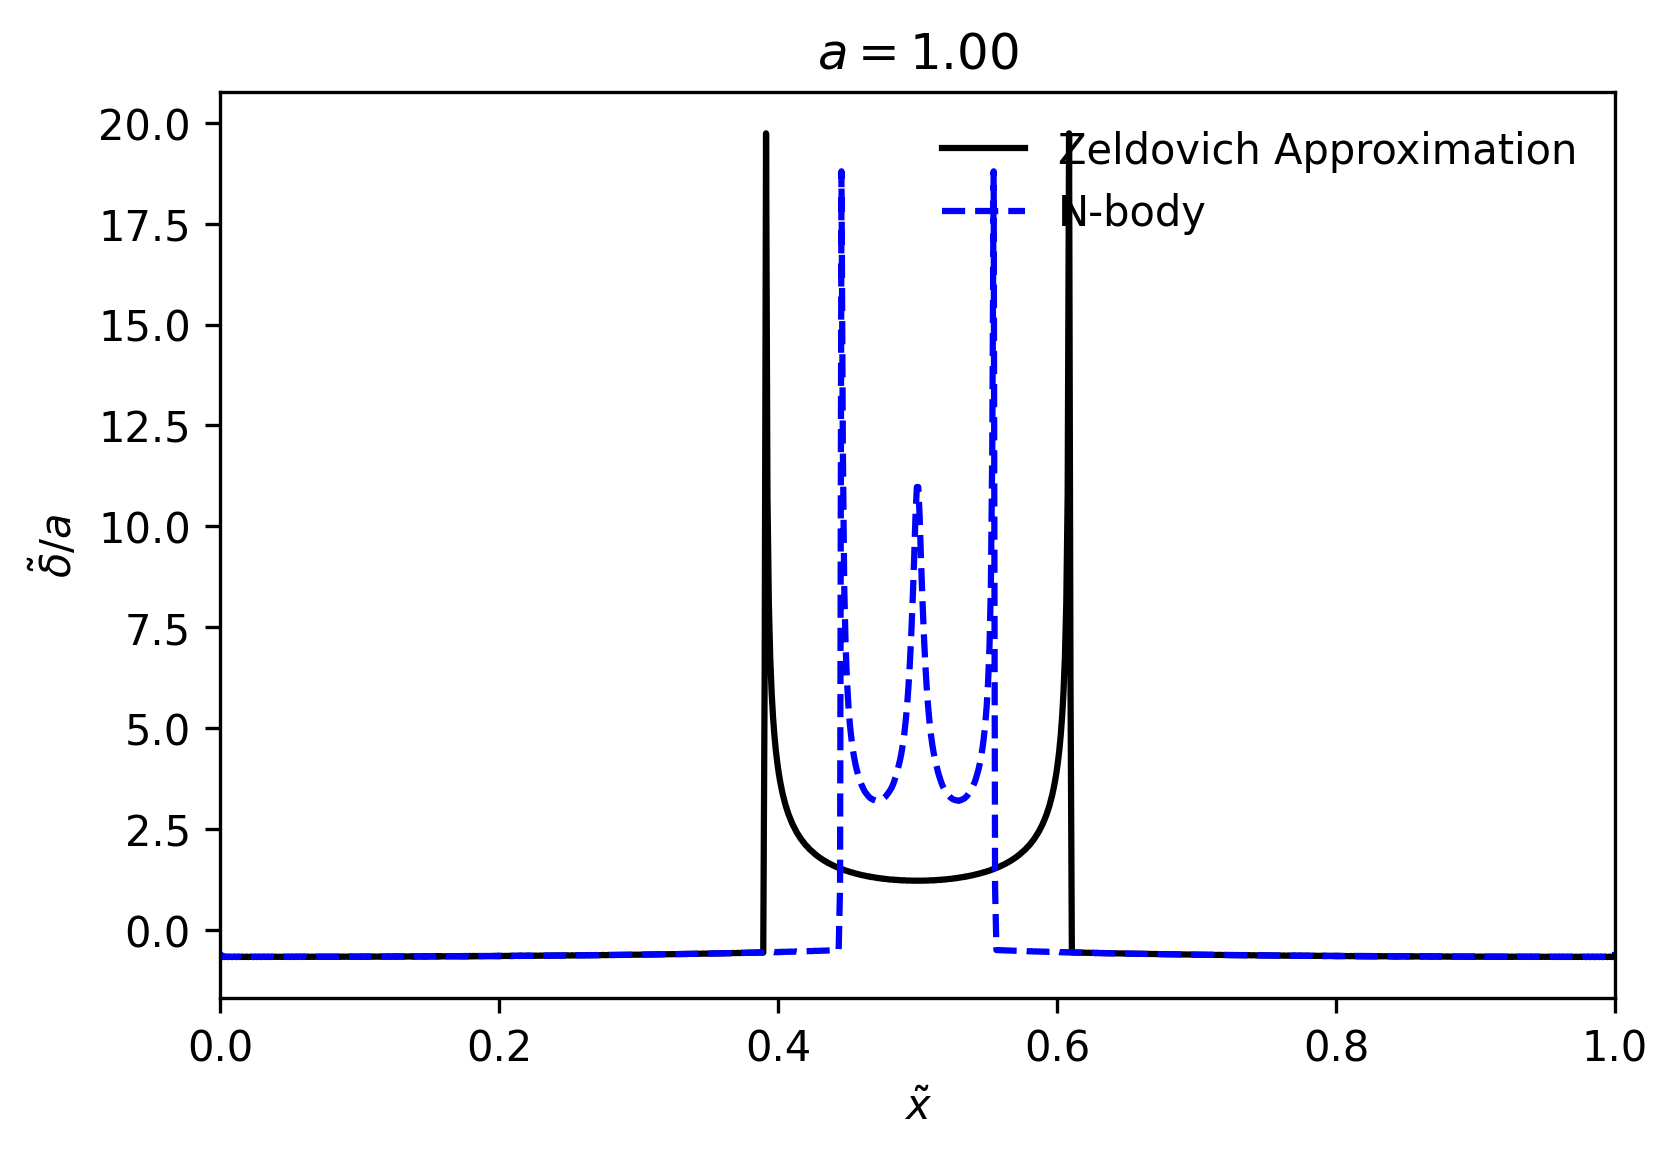

100%|██████████| 9011/9011 [00:12<00:00, 740.94it/s] 


In [17]:
# resolution of simulation
Ngrid = 10 ** 3
Np    = 10 ** 4

# parameters for simulation
aini = 0.1
across = 0.5
da = 0.0001
afinal = 1.0011
N_steps = int((afinal - aini) // da)

#collapse of plane wave
q = np.linspace(0,1, Np) # uniform in Lagrangian space
Amp = 1/(across * 2 * np.pi) # amplitude of initial velocity perturbation

#IC from Zeldovich Approx 
x = q + aini * Amp *np.sin(2 * np.pi * q) 
p = aini * (np.sqrt(aini) * Amp  * np.sin(2 * np.pi * q) )


def central_difference(y):
    return (np.roll(y,-1)-np.roll(y,1))/2

def rebin_grad_phi(x, grad_phi):
    left = x-0.5 / Ngrid
    xi = np.int64(left * Ngrid)
    frac = (1.+xi-left * Ngrid)
    return (frac)*(np.roll(grad_phi,0))[xi] + (1.-frac) * (np.roll(grad_phi,-1))[xi] 
    
curr_a = aini
from tqdm import trange
for i in trange(N_steps):
    if(i % 1000 == 0):
        # compare our simulaiton so far with exact analytical result
        plt.figure(dpi = 300, facecolor = 'w')
        theory_x = q + curr_a * Amp *np.sin(2 * np.pi * q)
        theory_p = curr_a * (curr_a * 1 / np.sqrt(curr_a) * Amp  * np.sin(2 * np.pi * q) )
        
        plt.plot(theory_x, theory_p, 'k', label='Zeldovich Approximation')
        plt.scatter(x[::len(q) // 100], p[::len(q) // 100], c='b', s=8, marker='x', label='N-body')

        plt.legend(frameon = False)
        plt.xlim(0,1)
        plt.xlabel(r'$\tilde x$')
        plt.ylabel(r'$\tilde p$')
        plt.title(r'$a=%.2f$'%(curr_a))
        plt.show()
    

    #kick
    _rho = CIC_deposit(x, Ngrid = Ngrid)
    assert(np.abs(_rho.mean()-1) < 1e-3) # a consistency check, this should be one
    _rho = _rho - _rho.mean()

    _phi = solve_poisson(_rho, curr_a)
    grad_phi = central_difference(_phi) * len(_phi)
    ap = rebin_grad_phi(x, grad_phi)
    
    p = p - np.sqrt(curr_a) * da/2 * ap
    
    #drift
    x = x + curr_a**(-3/2) * da * p
    x = array_periodic_boundary(x)

    
    #kick
    curr_a += da/2
    _rho = CIC_deposit(x, Ngrid = Ngrid)
    assert(np.abs(_rho.mean()-1) < 1e-3)
    _rho = _rho - _rho.mean()
        
    _phi = solve_poisson(_rho, curr_a)
    grad_phi = central_difference(_phi) * len(_phi)
    ap = rebin_grad_phi(x, grad_phi)
    
    p = p - np.sqrt(curr_a) * da/2 * ap

    curr_a += da/2
    
    if(i % 1000 == 0):
        # compare our density contrast with exact analytical result
        theory_x = q + curr_a * Amp *np.sin(2 * np.pi * q)
        theory_rho = CIC_deposit(theory_x, Ngrid)
        assert(np.abs(theory_rho.mean()-1) < 1e-3)
        theory_rho = theory_rho - 1
        
        plt.figure(dpi = 300, facecolor = 'w')
        plt.plot(np.linspace(0,1,Ngrid), theory_rho / curr_a, 'k', label='Zeldovich Approximation')
        plt.plot(np.linspace(0,1,Ngrid), _rho / curr_a, 
                    'b--', label='N-body')

        
        plt.legend(frameon=False)
        plt.ylabel(r'$\tilde\delta / a$')
        plt.xlabel(r'$\tilde x$')
        plt.xlim(0,1)
        plt.title(r'$a=%.2f$'%(curr_a))
        plt.show()

Some remarks on what you're seeing. Up until shell crossing the Zeldovich approximation is exact. However once shell occurs ZA starts to fail. You also start to see the phase space sheet curl up which means at a given point $\tilde x$ you have multiple velocities. This cannot be the case for an ideal fluid and thus is the reason why the ideal fluid approximation made in cosmological perturbation theory needs amending on small scales. Understanding the curling up of the phase space sheets is in my opinion one of the nicer simple insights you can get from studying N-body simulations. For a bit more discussion see this [lecture by Fabian Schmidt](https://video.ictp.it/WEB/2024/2024_06_17-smr3945/2024_06_19-09_15-smr3945.mp4) starting at 46:06

Acknowledgments: I have to thank Tom Abel for very helpful discussions about N-body simulations and sharing some of his code which has trickled down into some bits of code you see in this handout.

*Note: For the full cosmological 1D N-body simulation, I am not sure if `python` will be fast enough. However once you have written the code in `python`, translating that to a faster language like `C` or `FORTRAN` hopefully will be much more straightforward than starting out by writing everything in a compiled language.*